In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scripts.processing import github_event_processor, github_active_developers
from scripts.oso_db import execute_query, execute_saved_query
from visualizations.contribution_heatmap import contribution_heatmap
from visualizations.stacked_area import activity_plot, EVENT_TYPES

In [2]:
result = execute_saved_query("events_by_project_namespace", params=["gitcoin", "GITHUB"])

In [3]:
forks = [
    'gitcoinco/mattermost-server',
    'gitcoinco/mattermost-webapp',
    'gitcoinco/mattermost-redux',
    'gitcoinco/mattermost-plugin-gitlab',
    'gitcoinco/django-cacheops',
    'gitcoinco/contract-metadata',
    'gitcoinco/discourse-adplugin',
    'gitcoinco/slack-protector',
    'gitcoinco/snapshot-spaces',
    'gitcoinco/sourcecred',
    'gitcoinco/cred',
    'gitcoinco/code_fund_ads',
    'gitcoinco/EIPs',
    'gitcoinco/codefund',
    'gitcoinco/lemonade-stand',
    'gitcoinco/coz-slack-ico-management-platform',
    'gitcoinco/desktop-app'
]

df = github_event_processor(result, forks=forks)
df.head()

project_slug project_name                github_repo contributor_name  \
0      gitcoin      Gitcoin     gitcoinco/grants-stack    thelostone-mc   
1      gitcoin      Gitcoin     gitcoinco/grants-stack      nfrgosselin   
2      gitcoin      Gitcoin  gitcoinco/passport-scorer          nutrina   
3      gitcoin      Gitcoin        gitcoinco/grant-hub     gravityblast   
4      gitcoin      Gitcoin         gitcoinco/passport          erichfi   

                 event_time     event_type        date    month quarter  
0 2022-12-08 09:23:46+00:00  ISSUE_CREATED  2022-12-08  2022-12  2022Q4  
1 2022-12-09 14:00:00+00:00  ISSUE_CREATED  2022-12-09  2022-12  2022Q4  
2 2022-12-13 21:11:32+00:00  ISSUE_CREATED  2022-12-13  2022-12  2022Q4  
3 2022-12-13 19:12:23+00:00  ISSUE_CREATED  2022-12-13  2022-12  2022Q4  
4 2022-12-14 09:19:00+00:00  ISSUE_CREATED  2022-12-14  2022-12  2022Q4

# Basic analysis

In [4]:
# first commit
df[df['event_type'] == 'COMMIT_CODE']['event_time'].min()

Timestamp('2017-07-10 10:52:12+0000', tz='UTC')

In [5]:
# total commits
len(df[df['event_type'] == 'COMMIT_CODE'])

13184

In [6]:
# total devs
len(df[df['event_type'] == 'COMMIT_CODE']['contributor_name'].unique())

250

In [7]:
# original repos
len(df['github_repo'].unique())

117

# Aggregate trends

In [8]:
devs = github_active_developers(df, event_filters=EVENT_TYPES, min_days=5)
devs

month     2017-07 2017-09 2017-10 2017-11 2017-12 2018-01 2018-02 2018-03  \
full-time       0       0       1       2       5       3       3       4   
part-time       1       2       2       3      11      14      12      17   
inactive        0       0       0       1       0       4      10      11   

month     2018-04 2018-05  ... 2023-01 2023-02 2023-03 2023-04 2023-05  \
full-time       6       5  ...      19      11      15      19      19   
part-time      20      24  ...      17      18      16      18      16   
inactive       15      17  ...     205     213     214     211     215   

month     2023-06 2023-07 2023-08 2023-09 2023-10  
full-time      17      17      19      12       3  
part-time      22      16      17      19      24  
inactive      215     223     223     230     234  

[3 rows x 75 columns]

Text(0.5, 0, '')

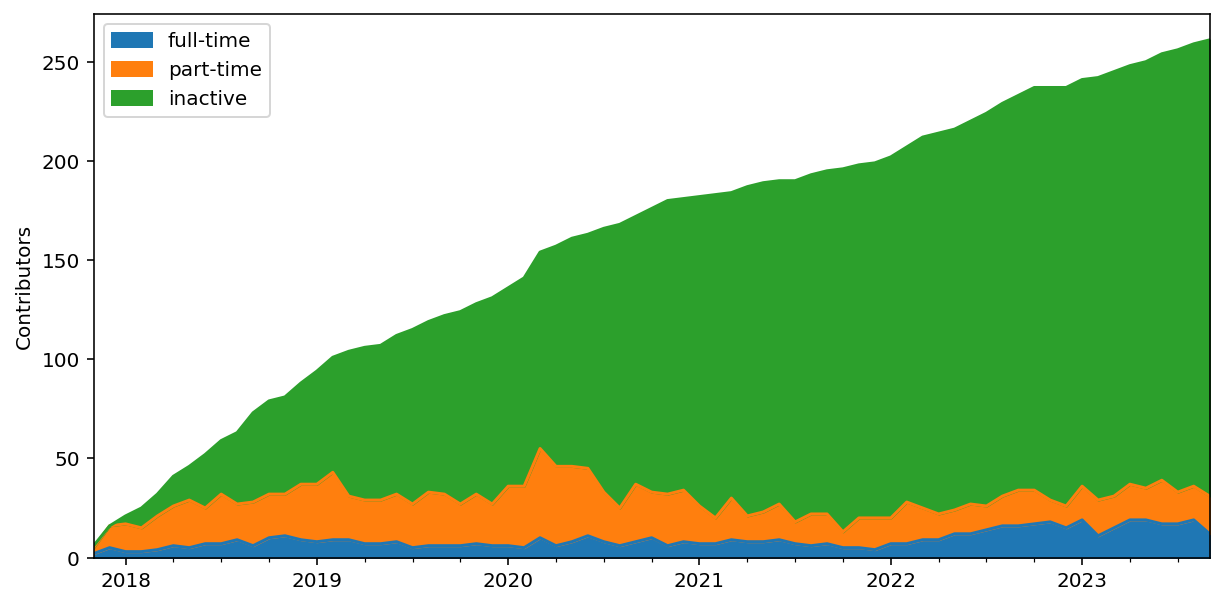

In [9]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144)
devs.iloc[:,3:-1].T.plot(kind='area', ax=ax)
ax.set_ylabel("Contributors")
ax.set_xlabel("")

Text(0.5, 0, '')

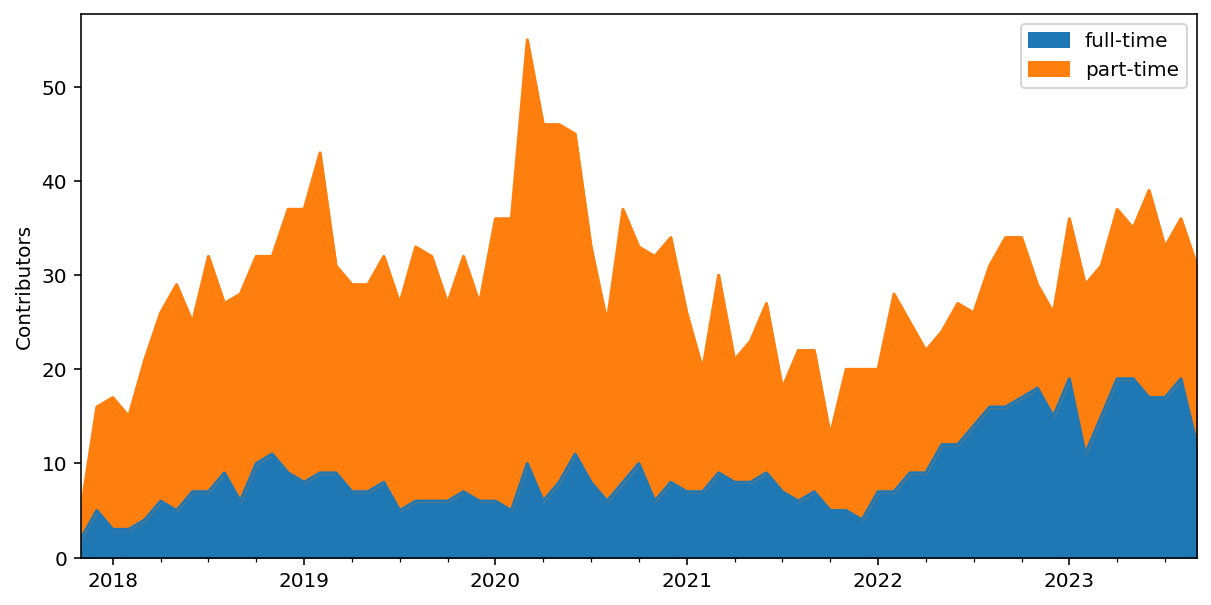

In [10]:
fig, ax = plt.subplots(figsize=(10,5), dpi=144)
devs.iloc[:,3:-1].T[['full-time', 'part-time']].plot(kind='area', ax=ax)
ax.set_ylabel("Contributors")
ax.set_xlabel("")

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

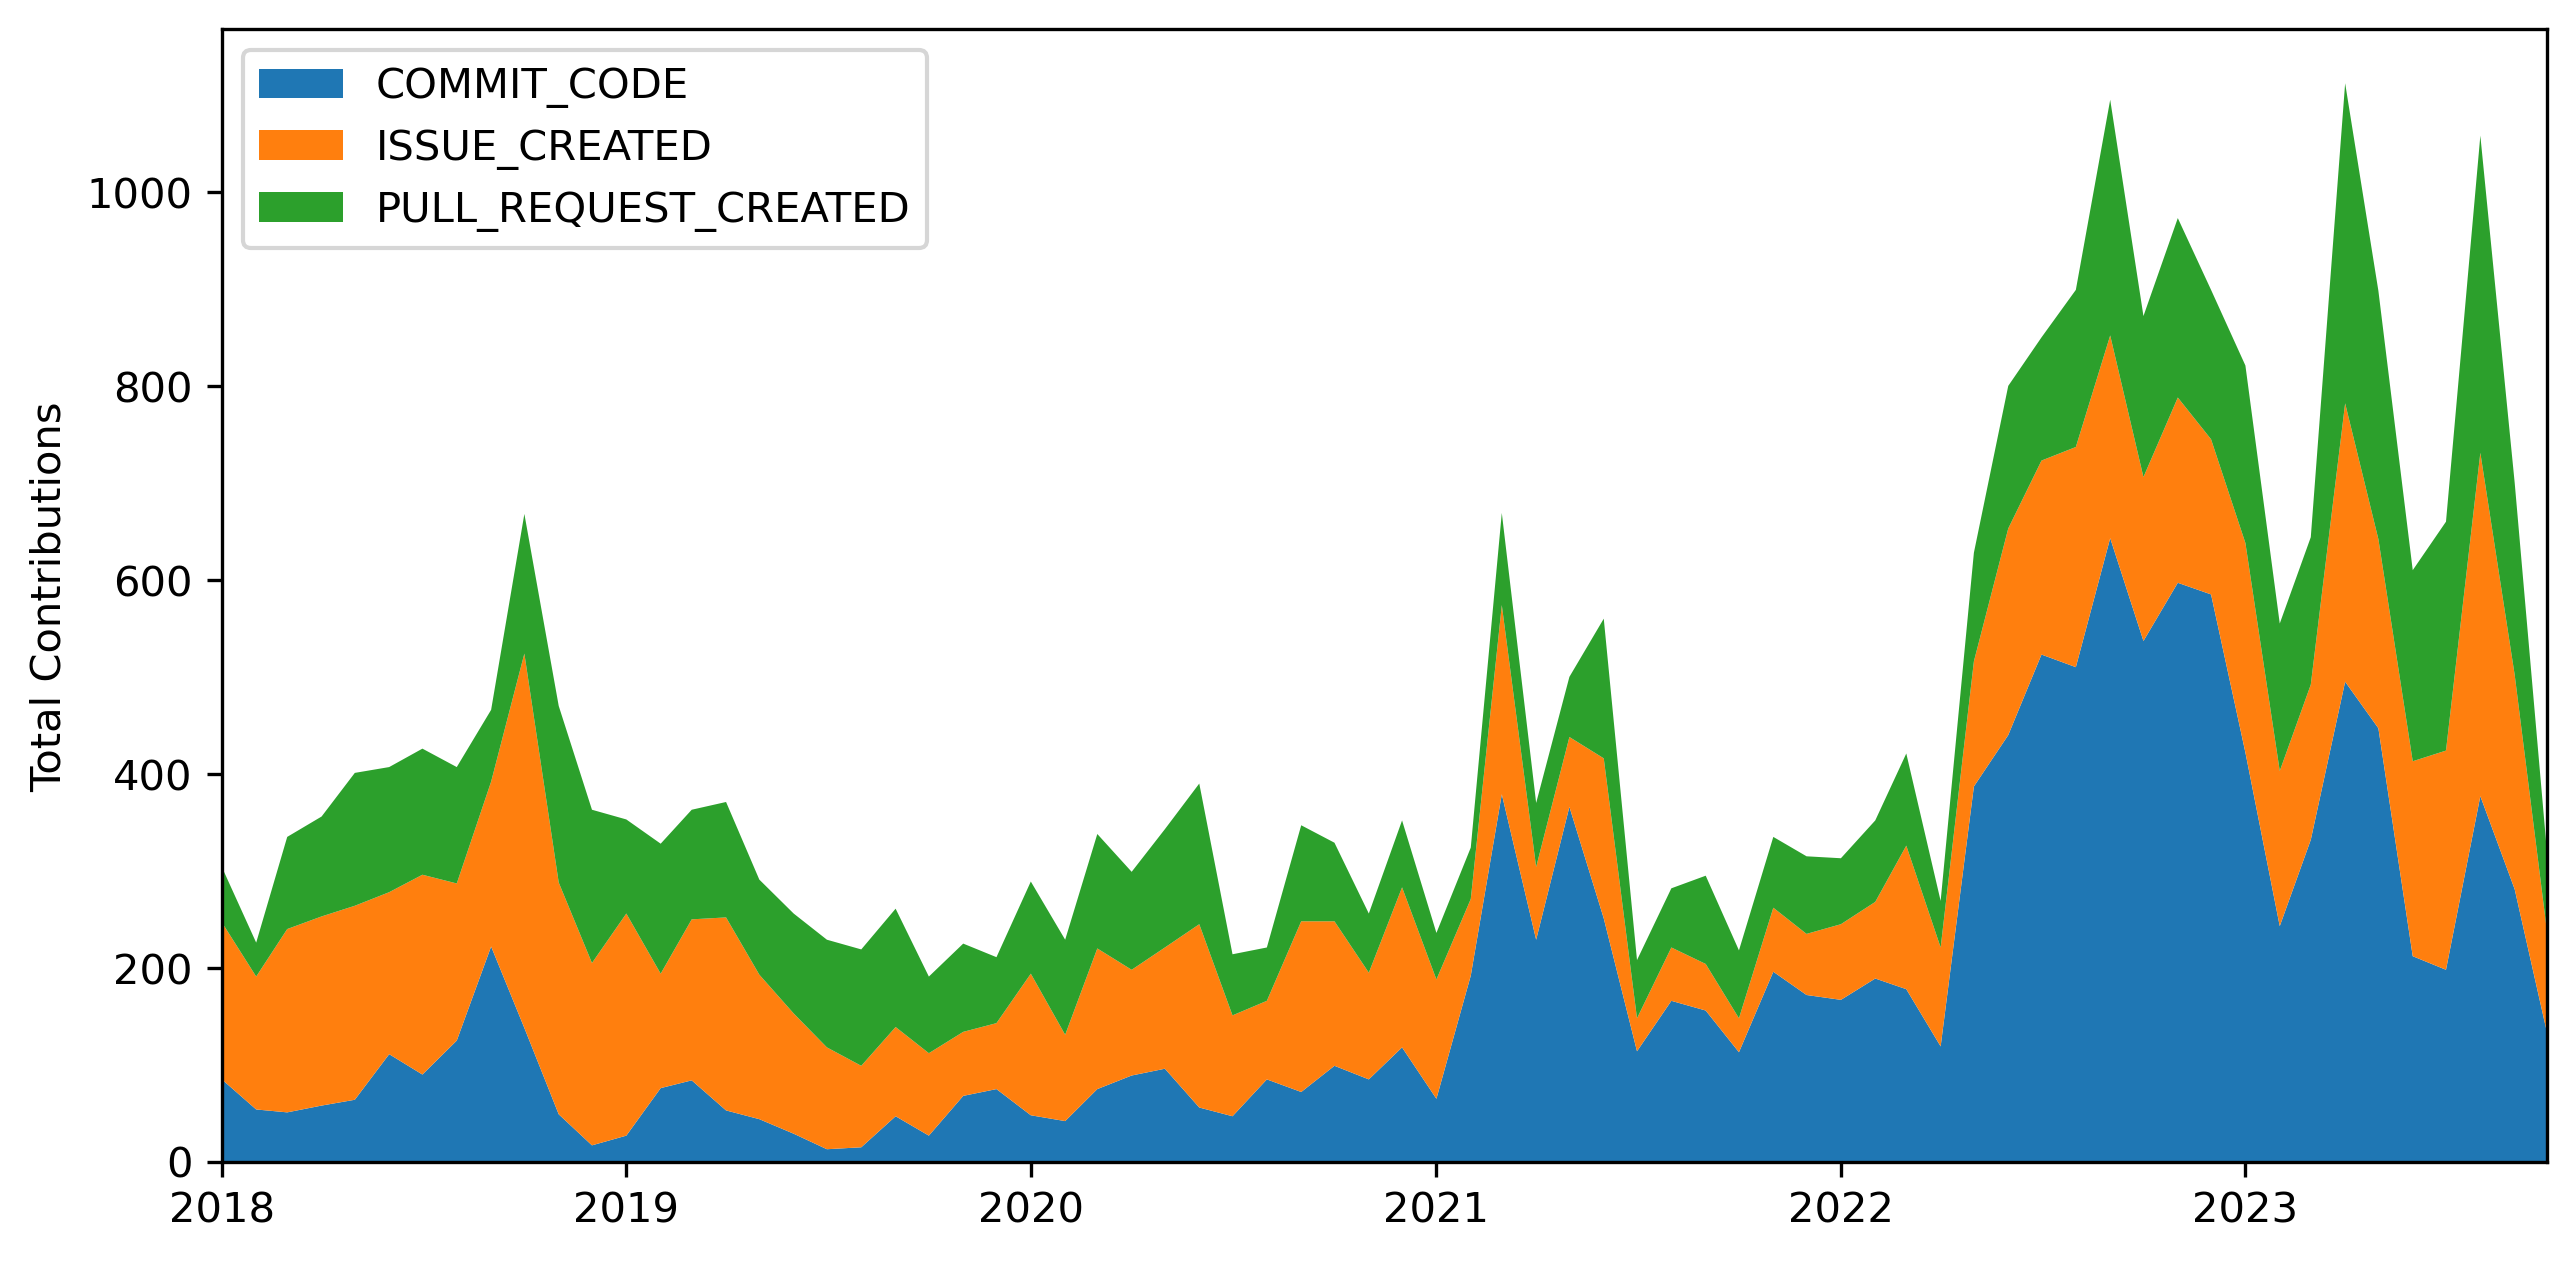

In [11]:
activity_plot(
    df, 
    grouper_col='event_type', 
    date_col='month', 
    start_date='2018-01-01',
    end_date='2023-09-30',
    filter_vals=['COMMIT_CODE', 'PULL_REQUEST_CREATED', 'ISSUE_CREATED']
)

(<Figure size 3000x1500 with 1 Axes>,
 <AxesSubplot:ylabel='Total Contributions'>)

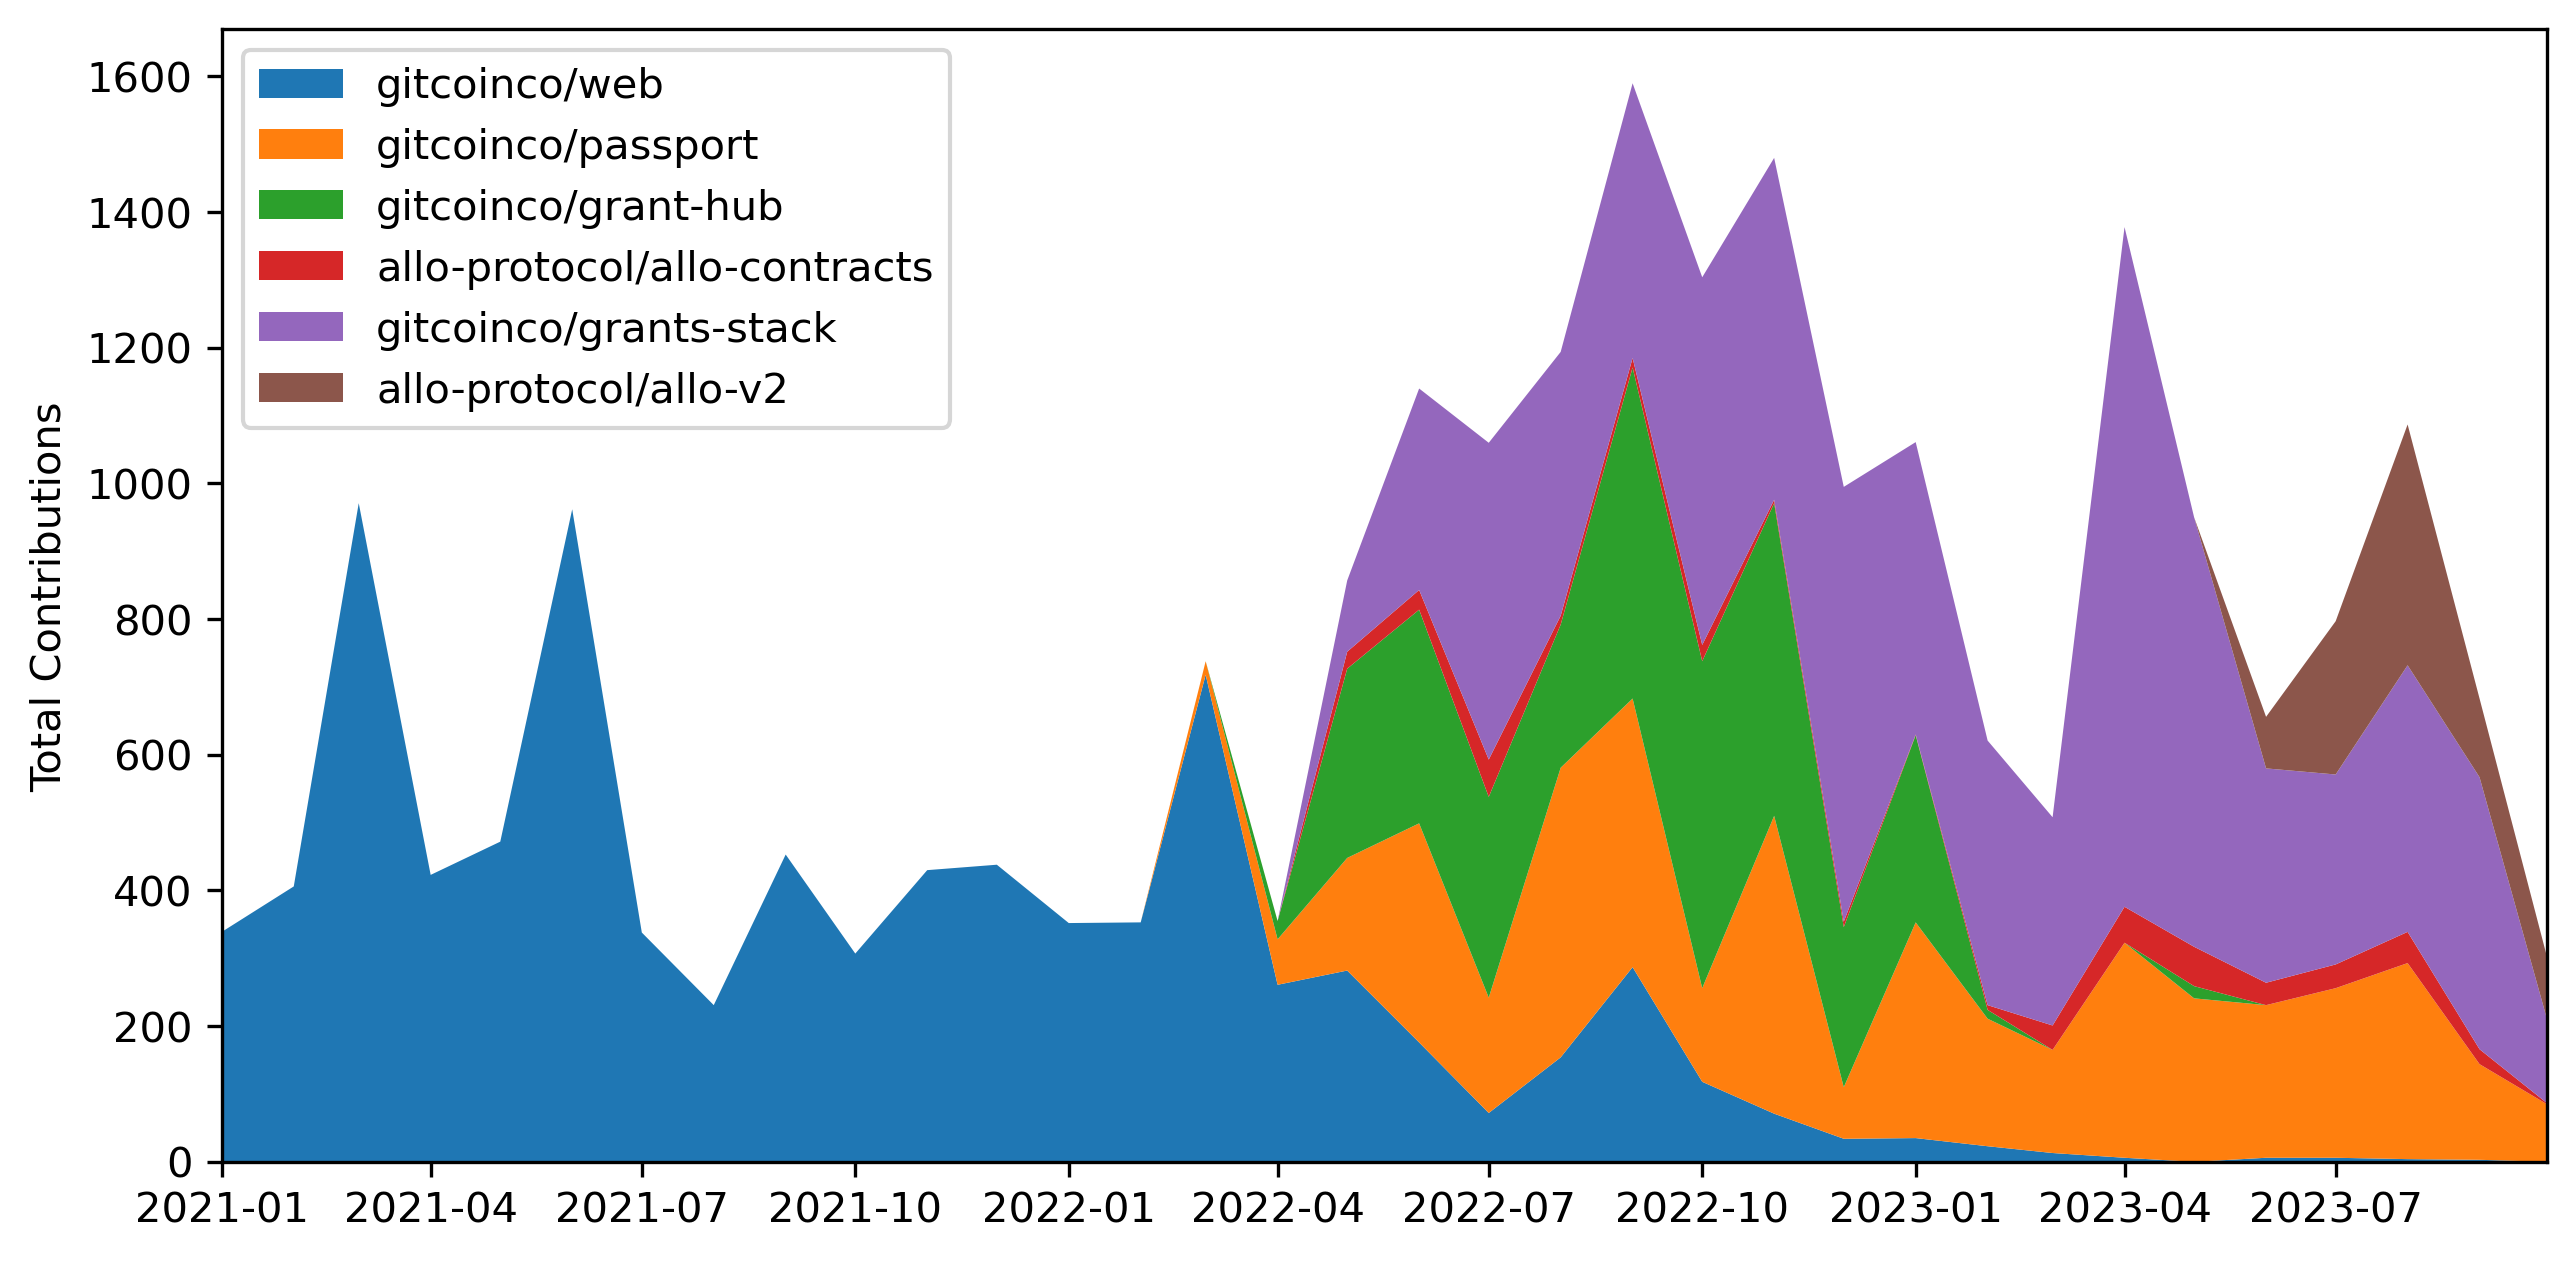

In [12]:
key_repos = ['gitcoinco/web', 'gitcoinco/grants-stack', 'gitcoinco/passport', 
             'gitcoinco/grant-hub', 'allo-protocol/allo-v2', 'allo-protocol/allo-contracts']

activity_plot(
    df[df['github_repo'].isin(key_repos)], 
    grouper_col='github_repo', 
    date_col='month', 
    start_date='2021-01-01',
    end_date='2023-09-30',
    filter_vals=EVENT_TYPES
)

# Heatmapping

(<Figure size 2400x6600 with 1 Axes>, <AxesSubplot:>)

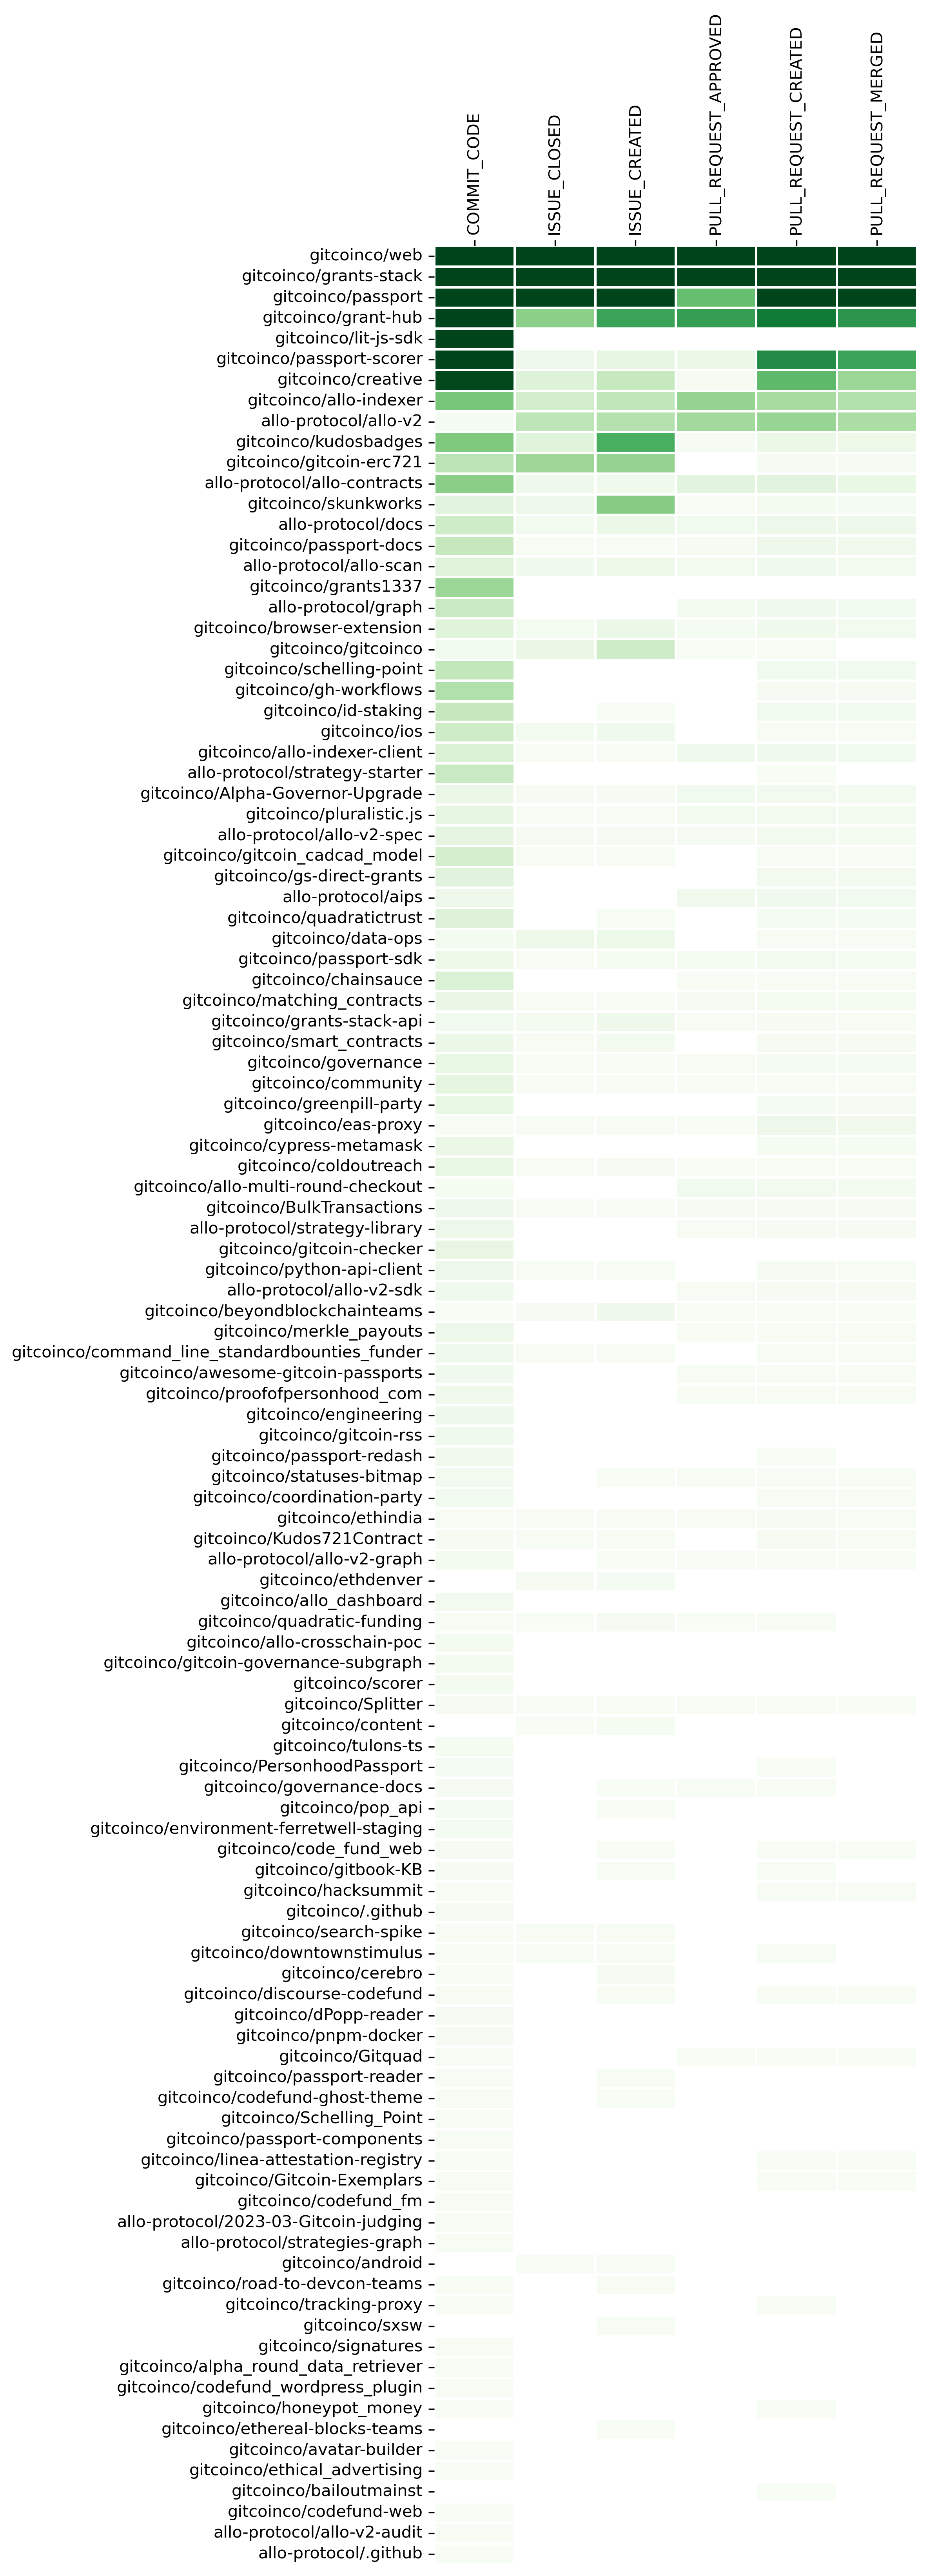

In [13]:
contribution_heatmap(
    df[df.event_type.isin(EVENT_TYPES)],
    index_col='github_repo',
    column_col='event_type',
    value_col='event_time',
    apply_groupby=True,
    figsize=(8,22),
    vmax=500,
    sort_label_method='mean'
)

(<Figure size 4500x6360 with 1 Axes>, <AxesSubplot:>)

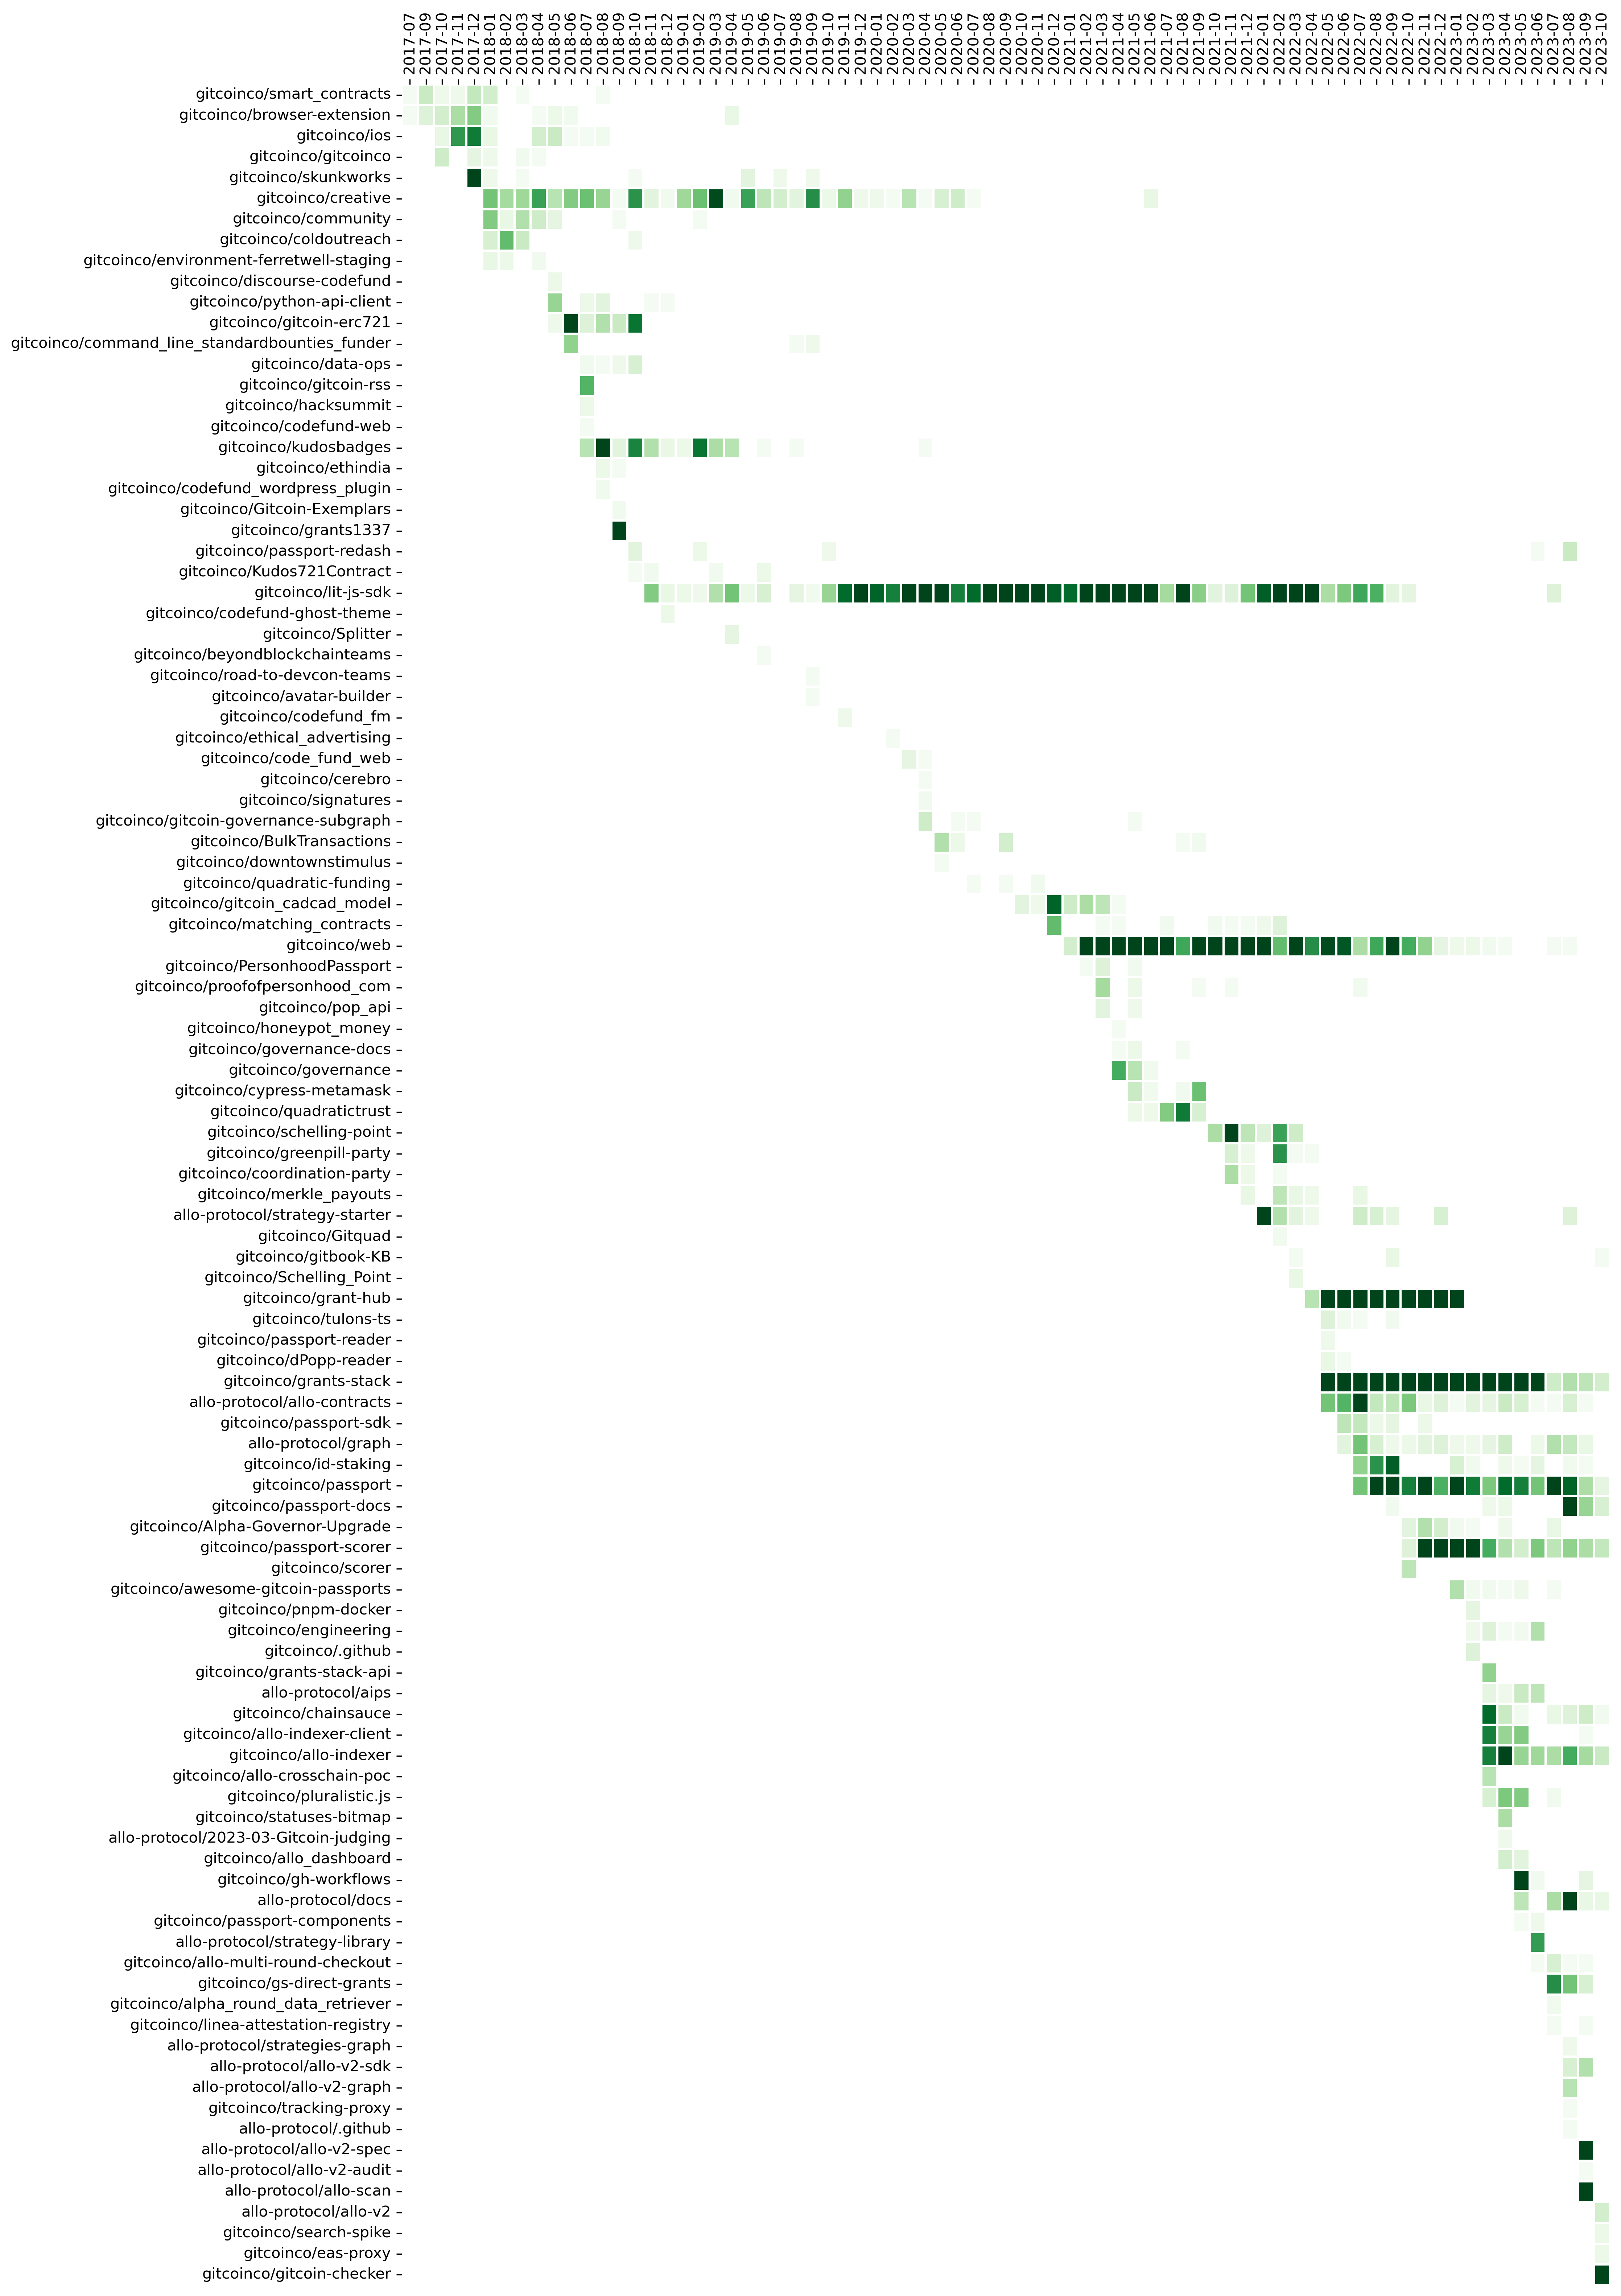

In [14]:
contribution_heatmap(
    df[df.event_type=='COMMIT_CODE'],
    index_col='github_repo',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=50
)

(<Figure size 4440x3780 with 1 Axes>, <AxesSubplot:>)

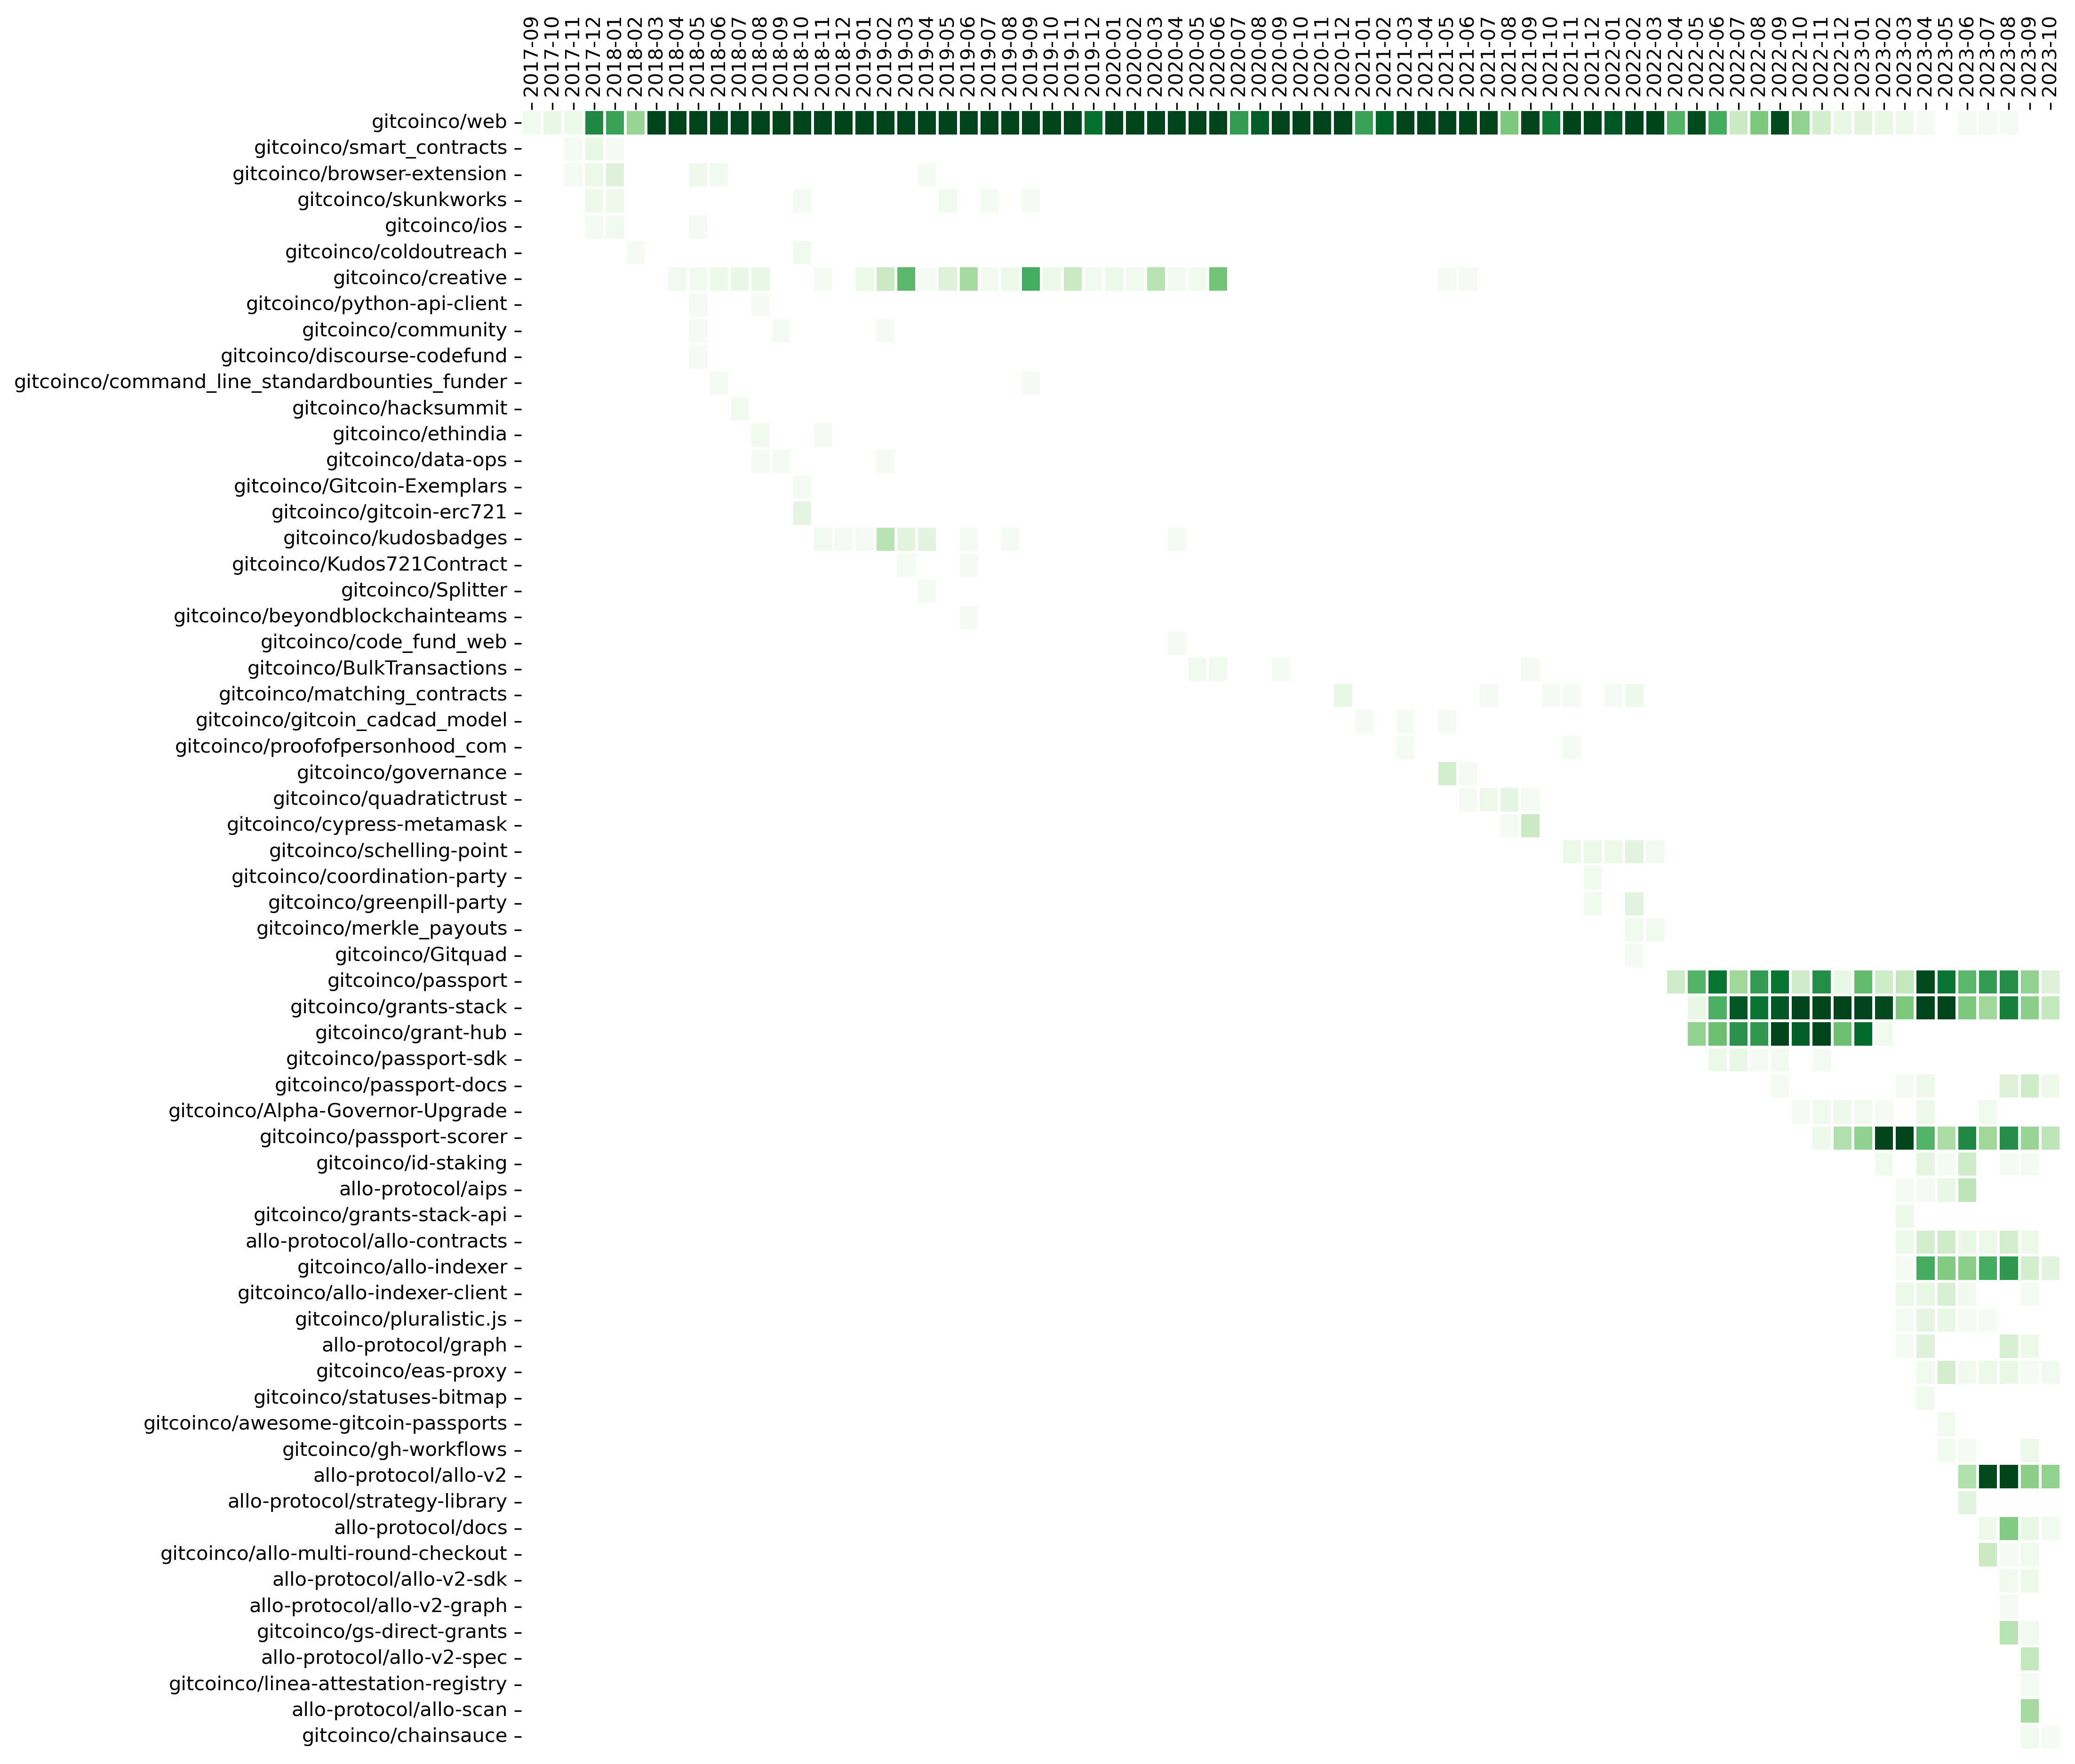

In [15]:
contribution_heatmap(
    df[df.event_type=='PULL_REQUEST_MERGED'],
    index_col='github_repo',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=50,
)

(<Figure size 4320x2700 with 1 Axes>, <AxesSubplot:>)

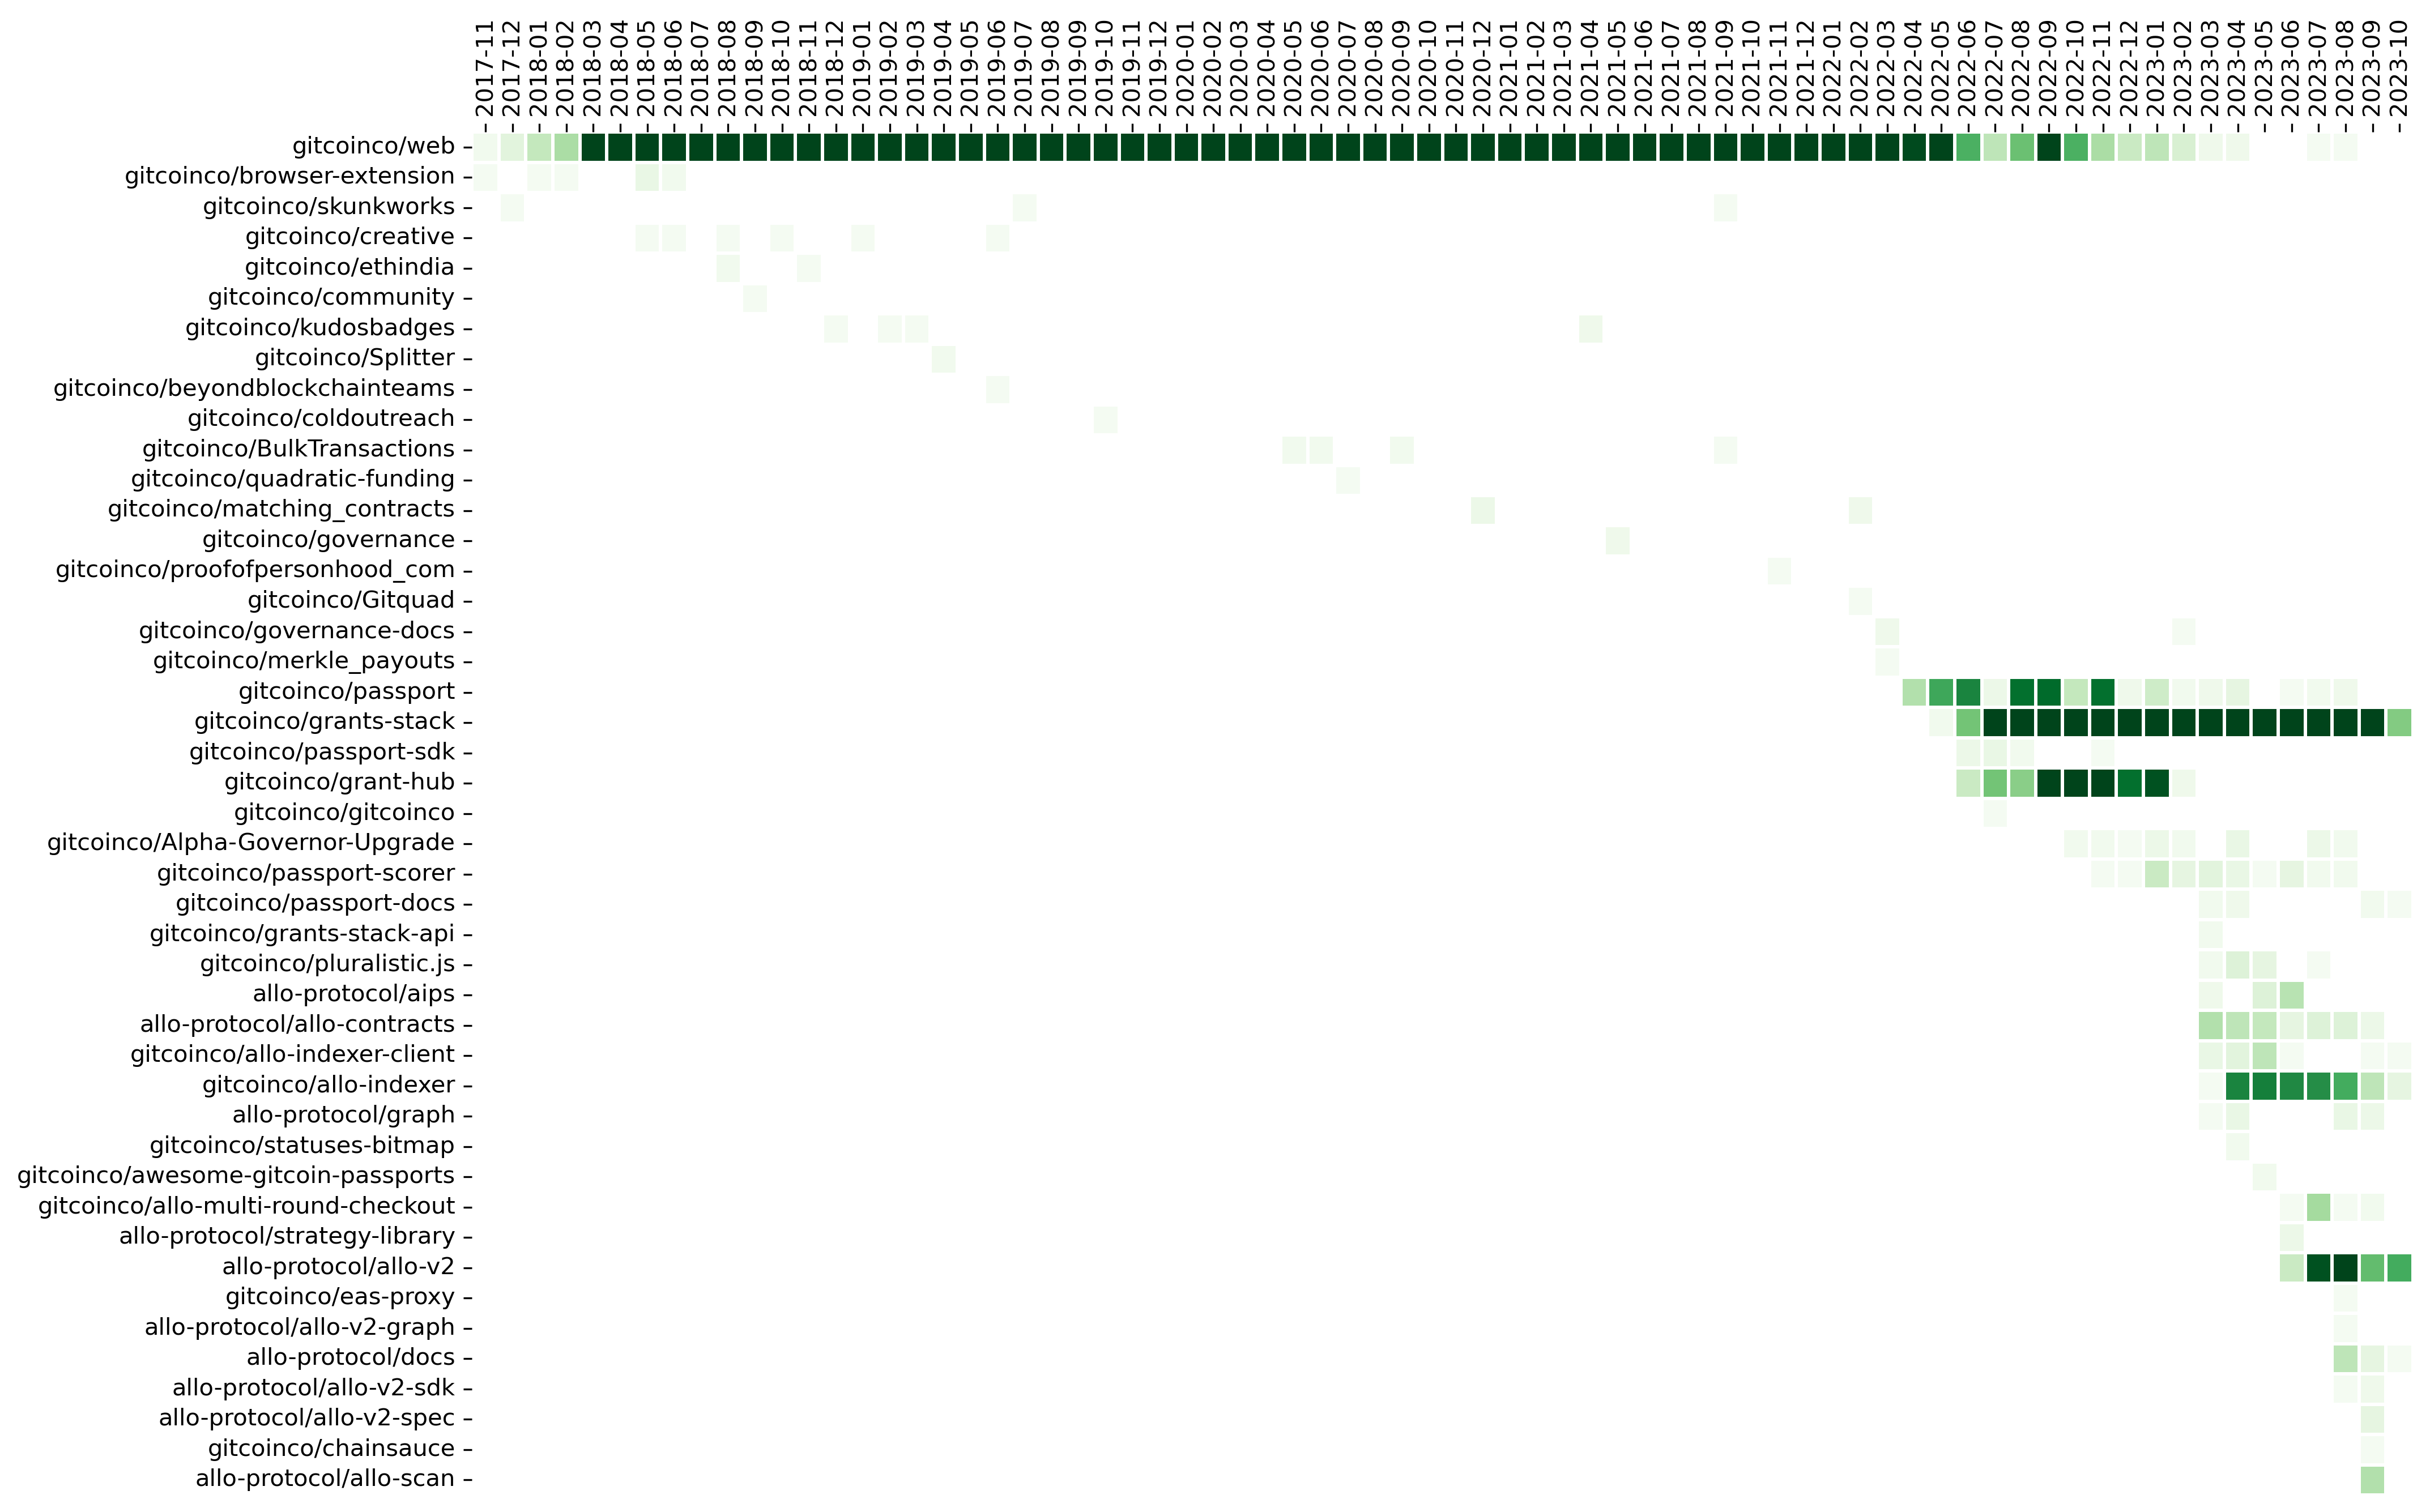

In [16]:
contribution_heatmap(
    df[df.event_type=='PULL_REQUEST_APPROVED'],
    index_col='github_repo',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=50,
)

(<Figure size 4440x2700 with 1 Axes>, <AxesSubplot:>)

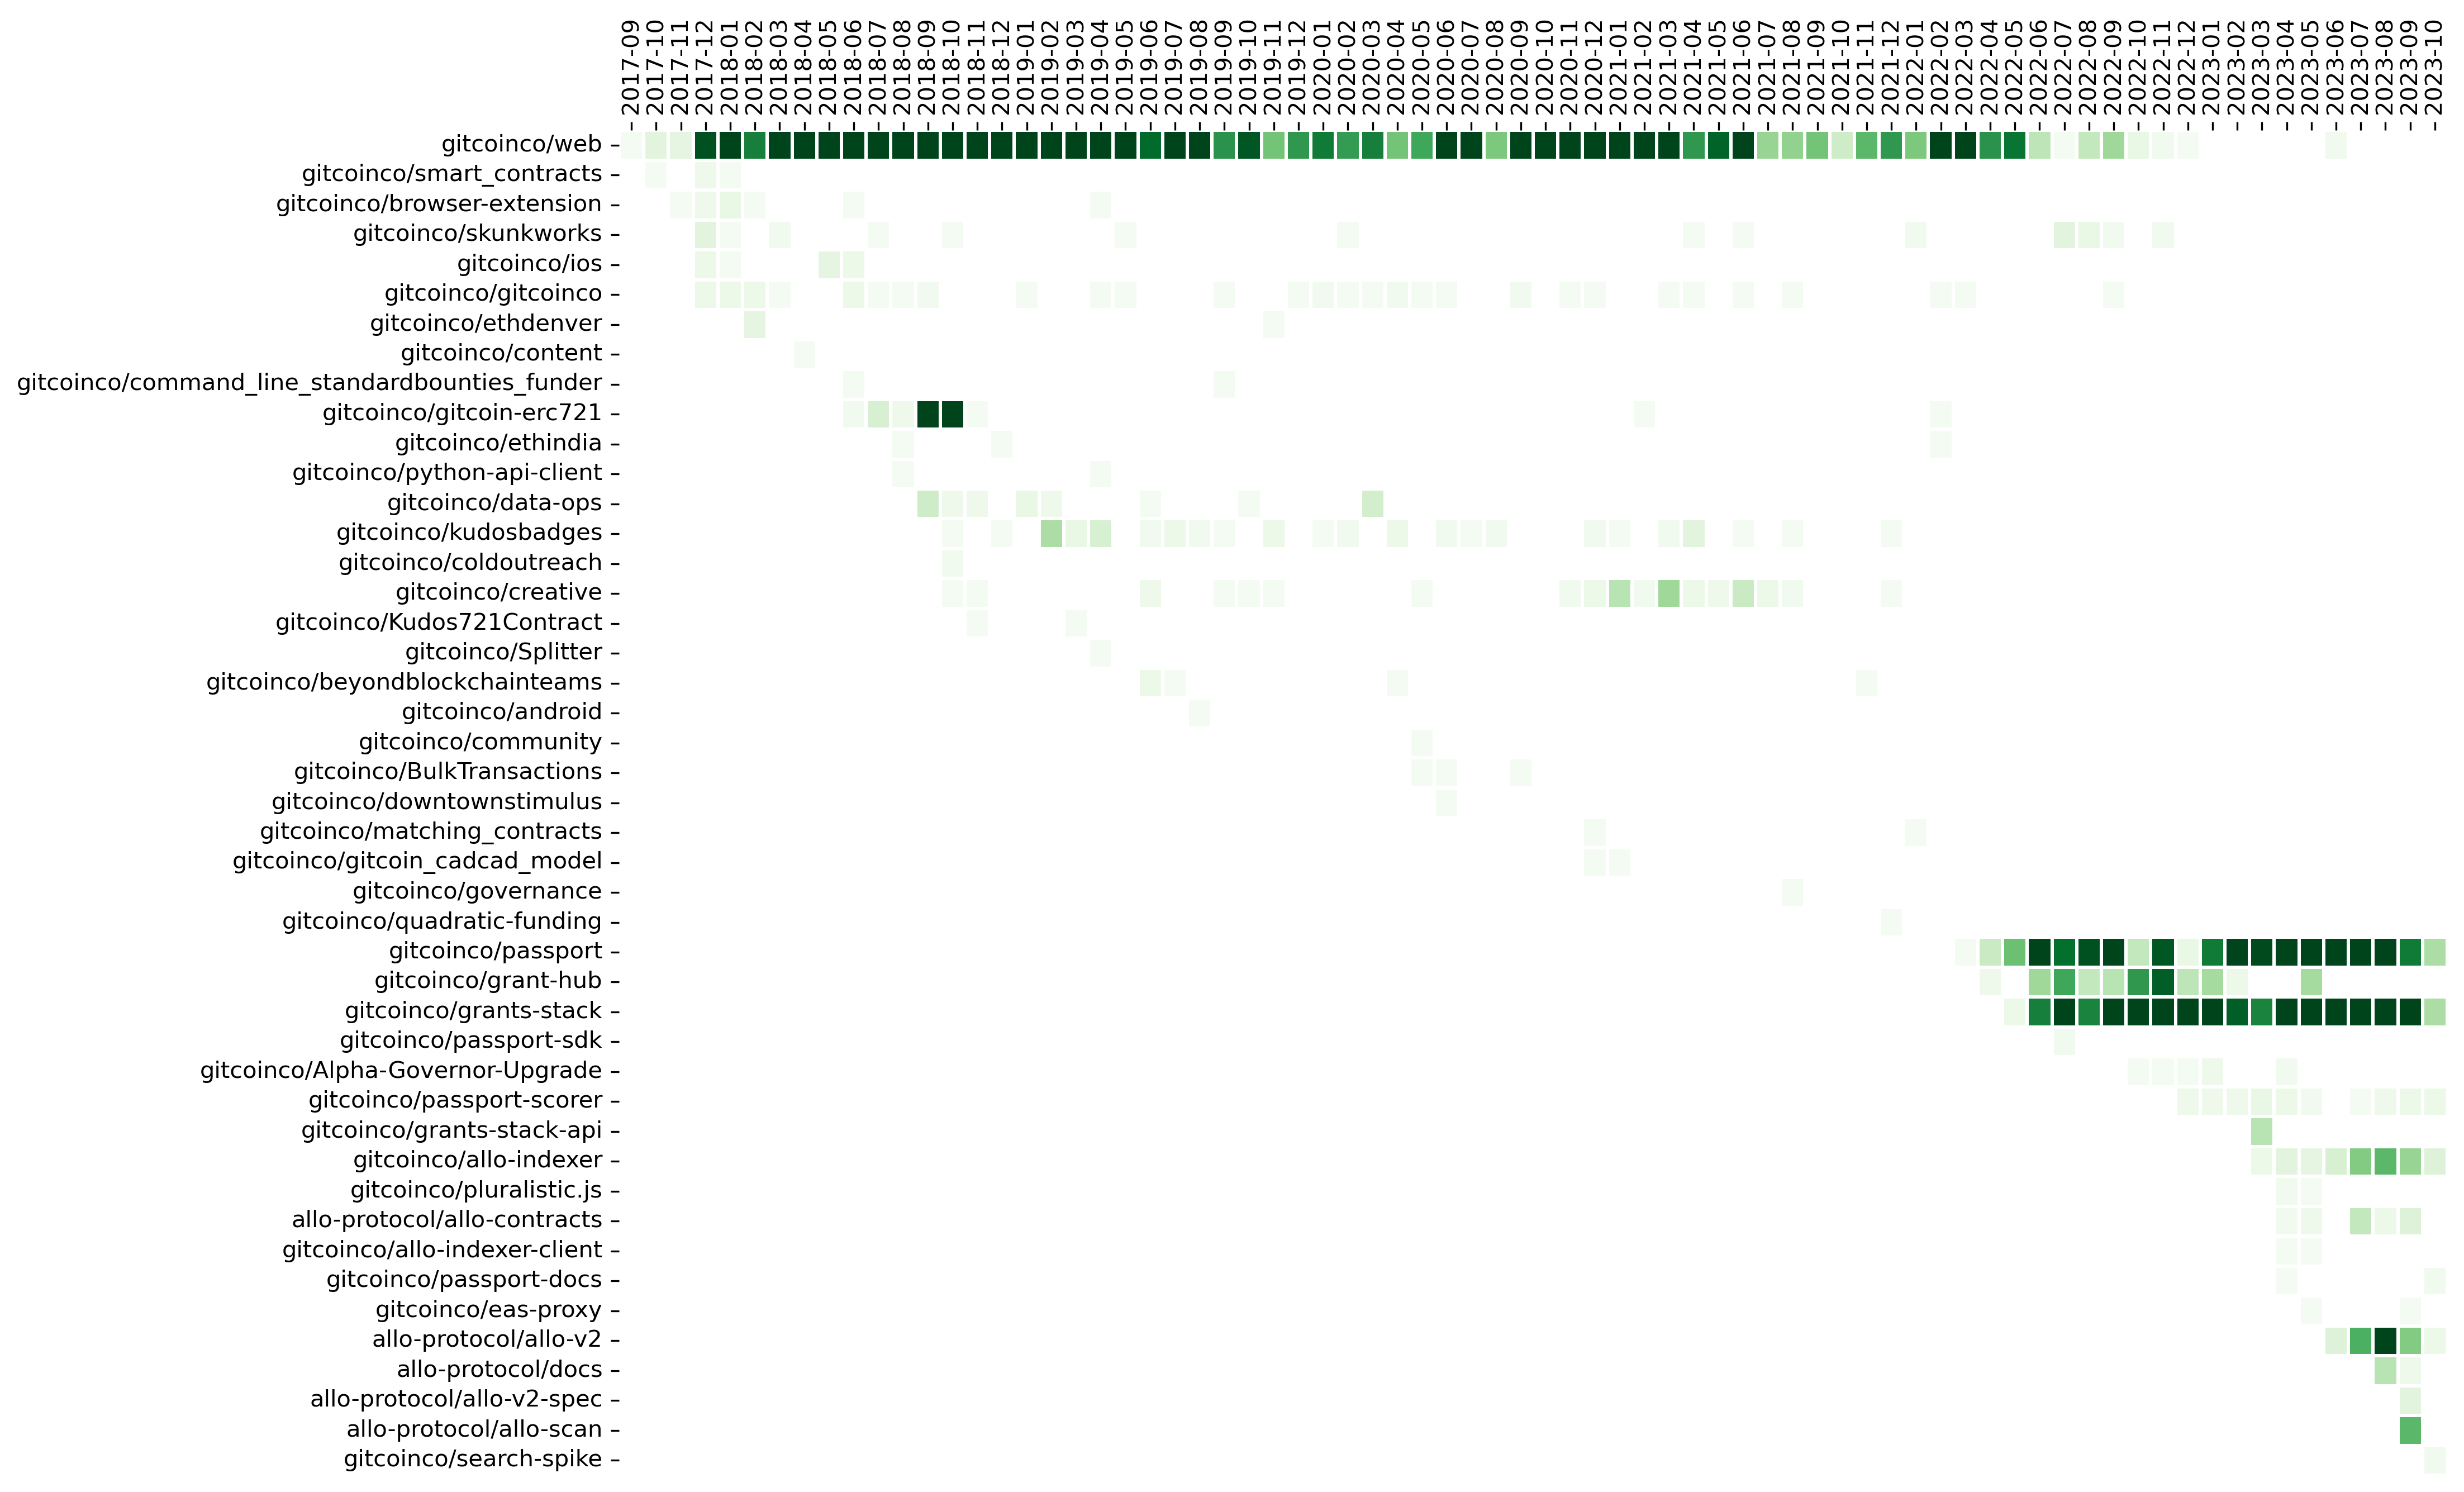

In [17]:
contribution_heatmap(
    df[df.event_type=='ISSUE_CLOSED'],
    index_col='github_repo',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=50,
)

(<Figure size 4500x6540 with 1 Axes>, <AxesSubplot:>)

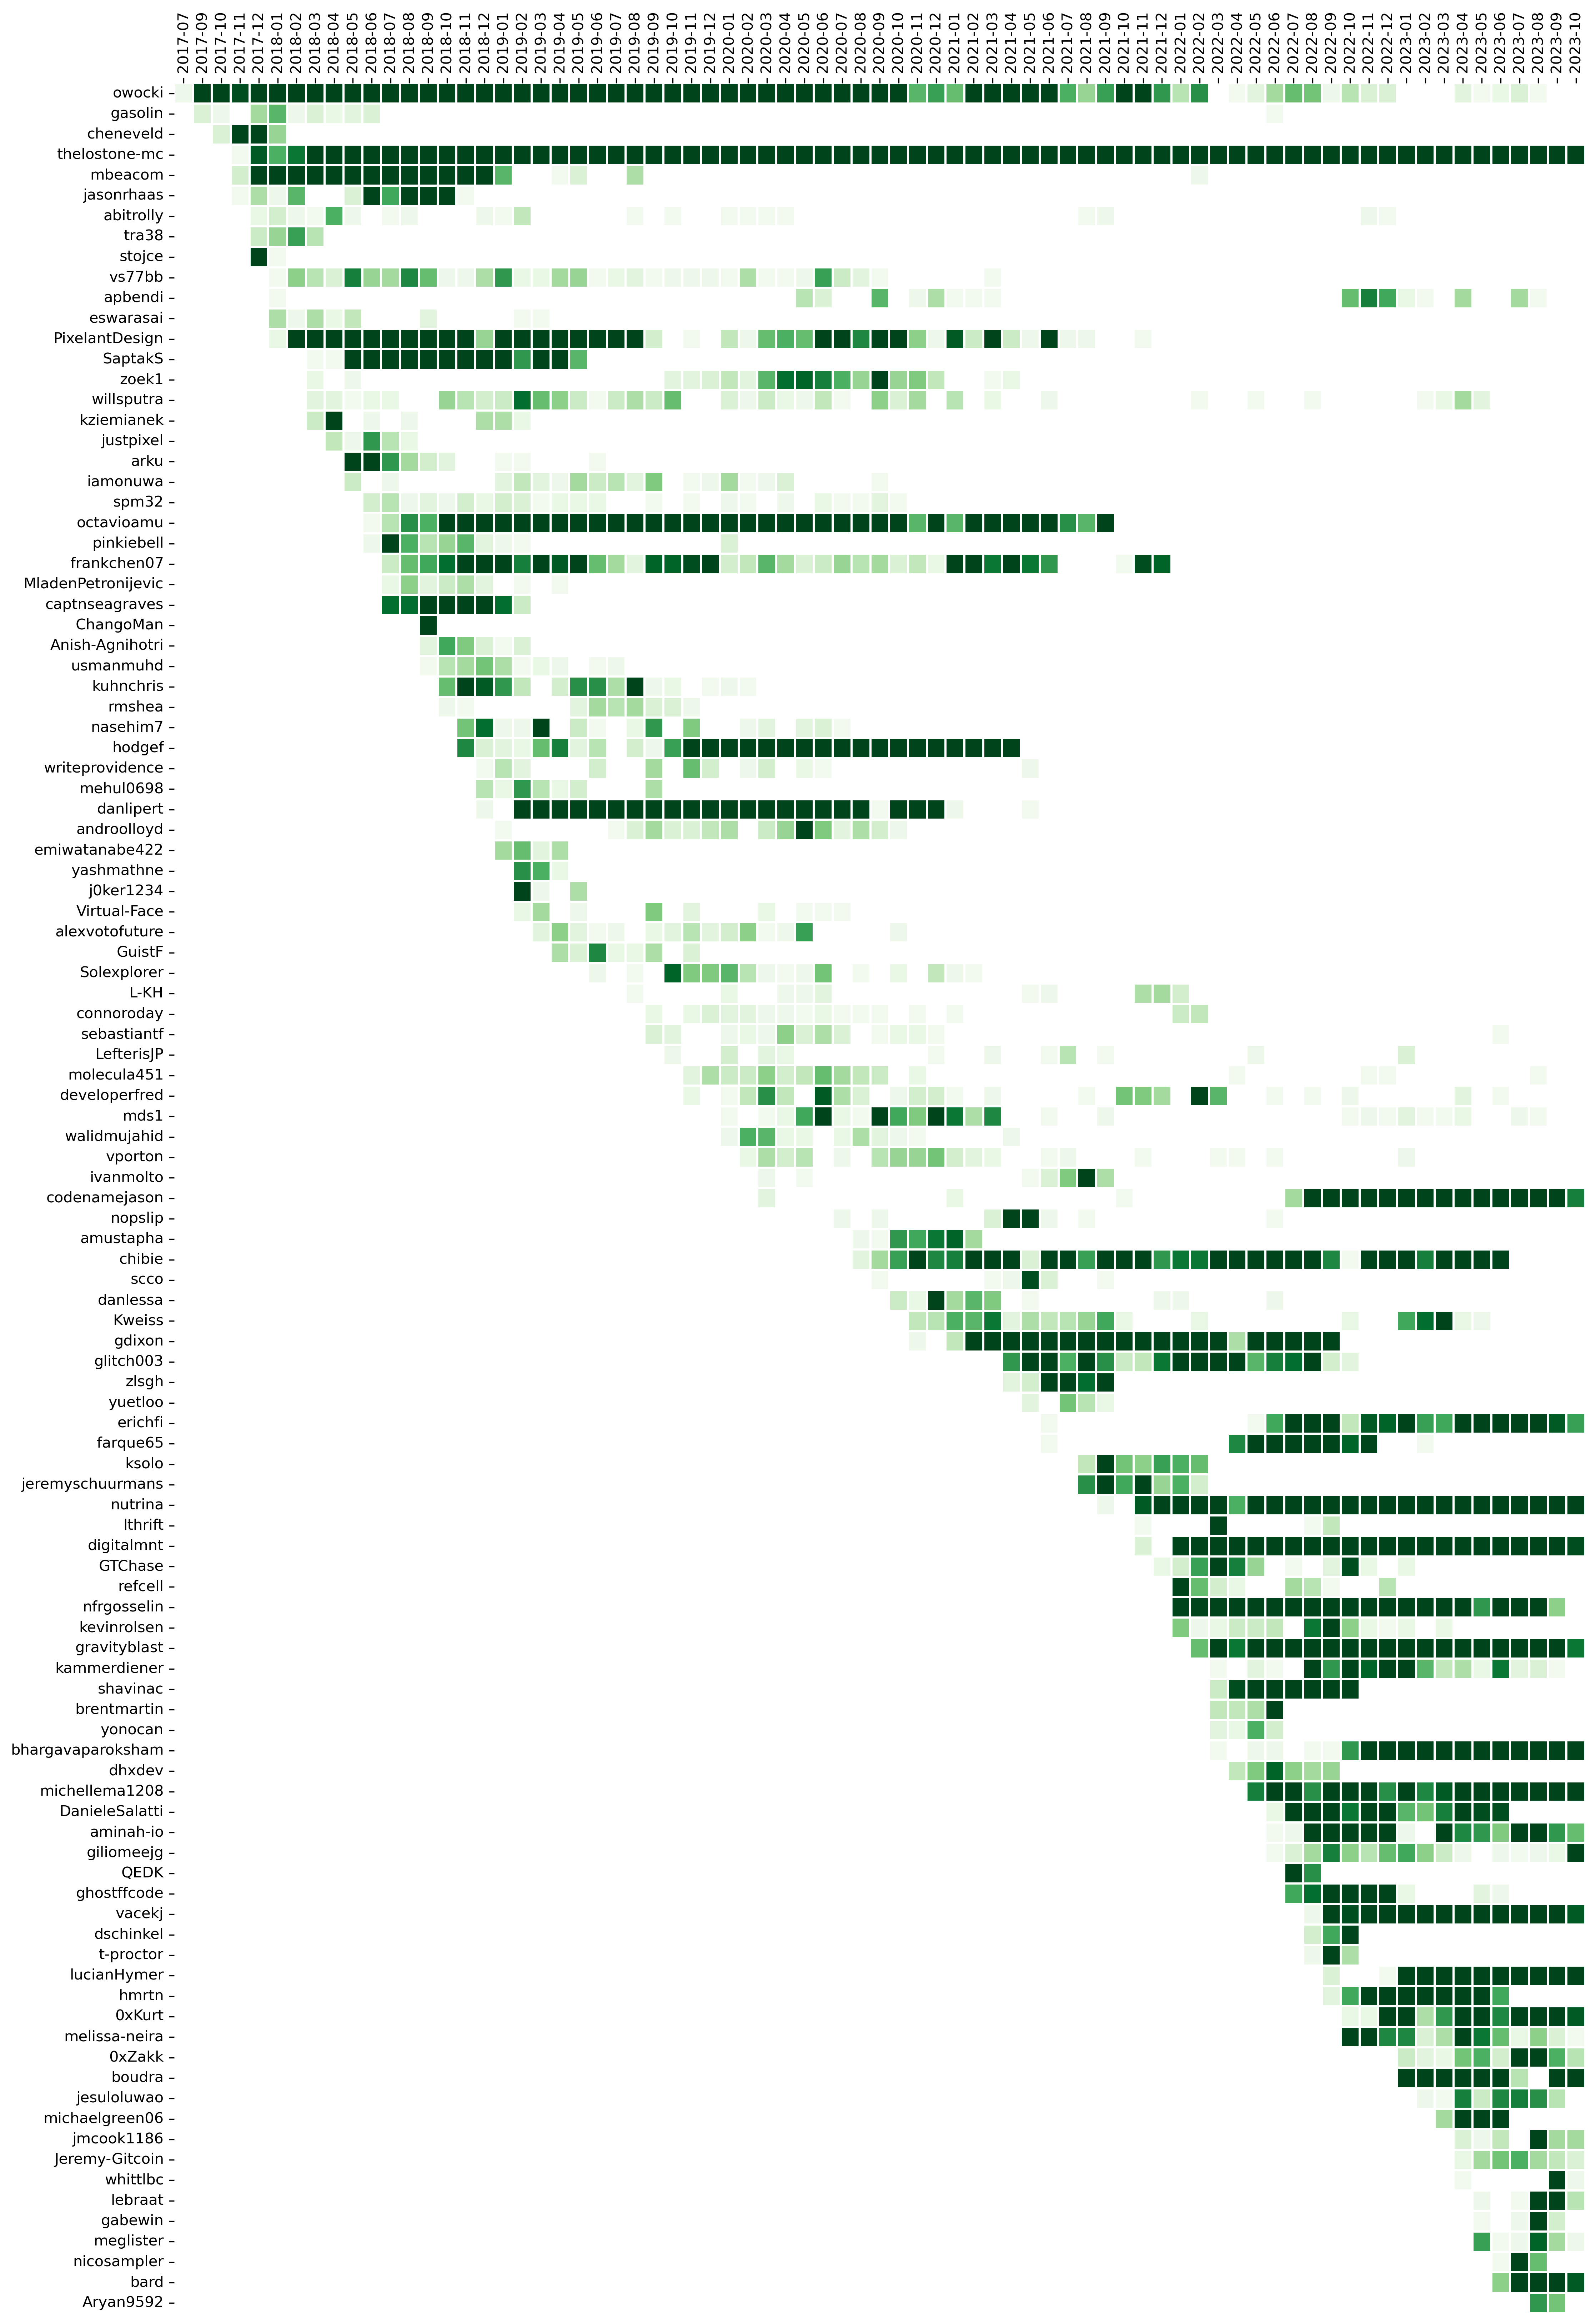

In [18]:
top_contribs = df[df.event_type.isin(EVENT_TYPES)]['contributor_name'].value_counts()
top_contribs = top_contribs[top_contribs>=30].index
top_contribs = [c for c in top_contribs if "@" not in c]

contribution_heatmap(
    df[df.contributor_name.isin(top_contribs)],
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=30
)

# Leaderboards

(<Figure size 2460x3720 with 1 Axes>, <AxesSubplot:>)

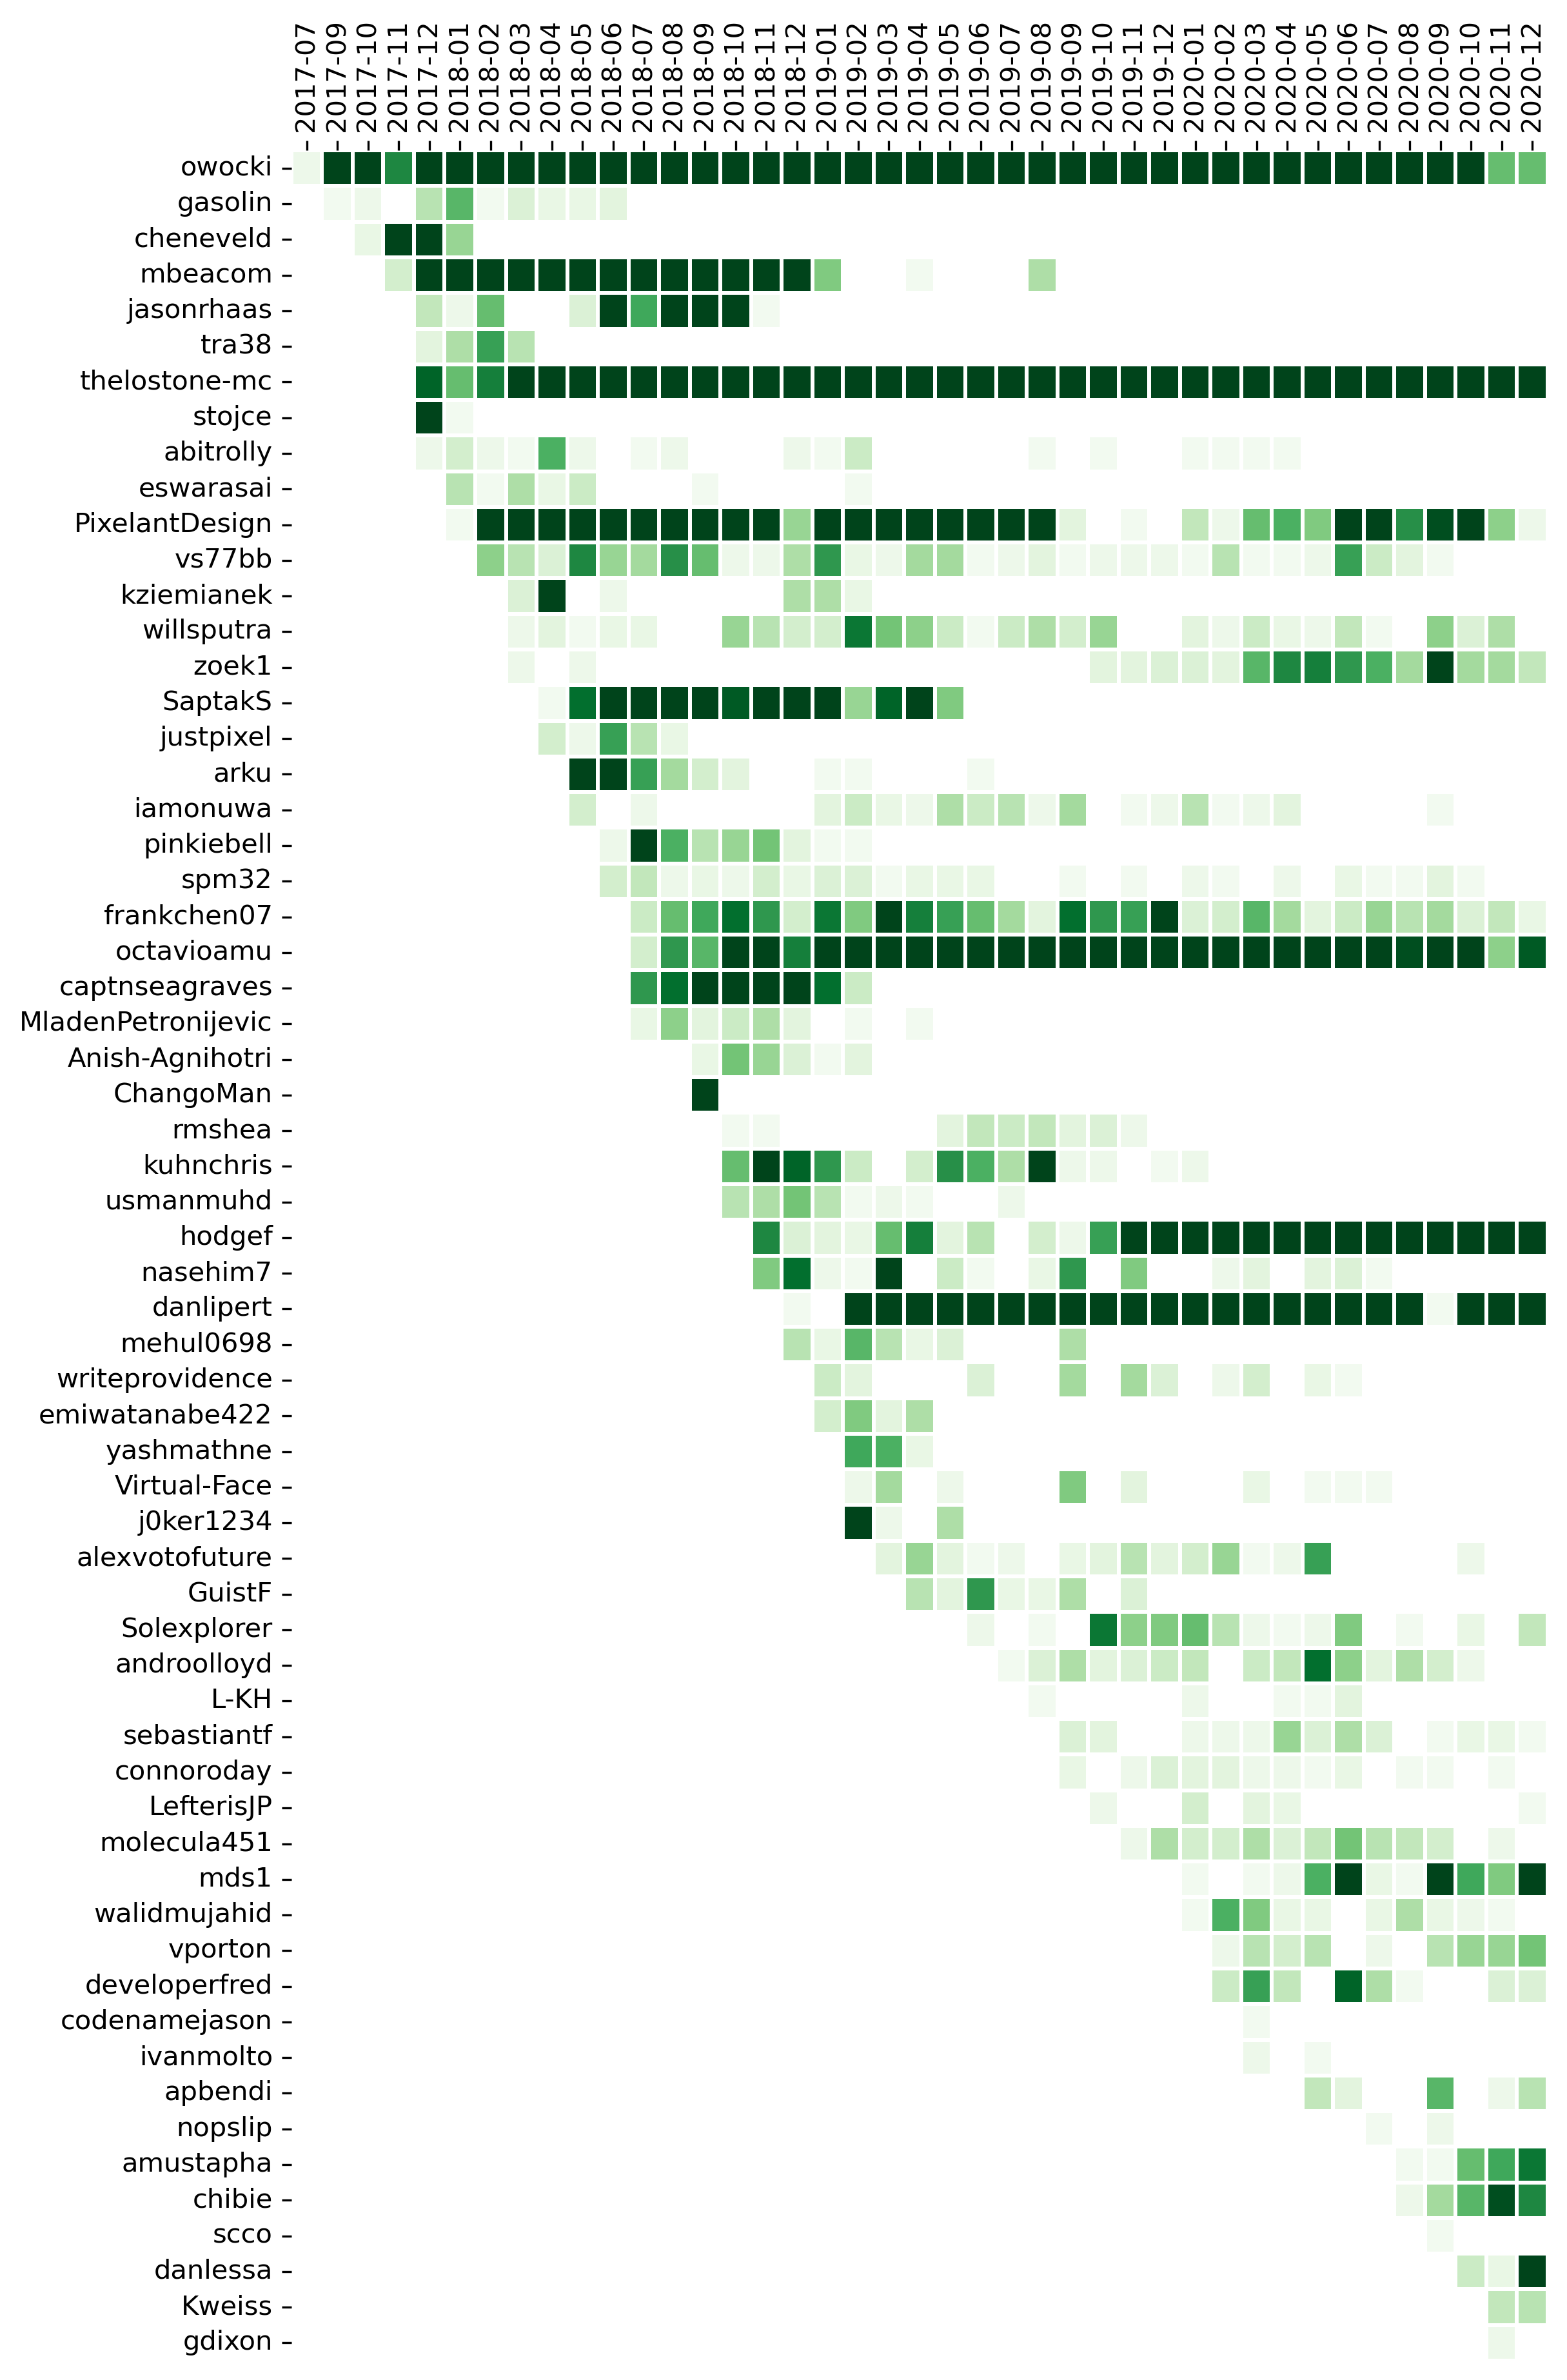

In [19]:
# OGs

dff = df[df['month'] < '2021-01'] 
dff = dff[dff['contributor_name'].isin(top_contribs)]
dff = dff[dff['event_type'].isin(EVENT_TYPES)]

contribution_heatmap(
    dff,
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=30,
)

(<Figure size 4320x1080 with 1 Axes>, <AxesSubplot:>)

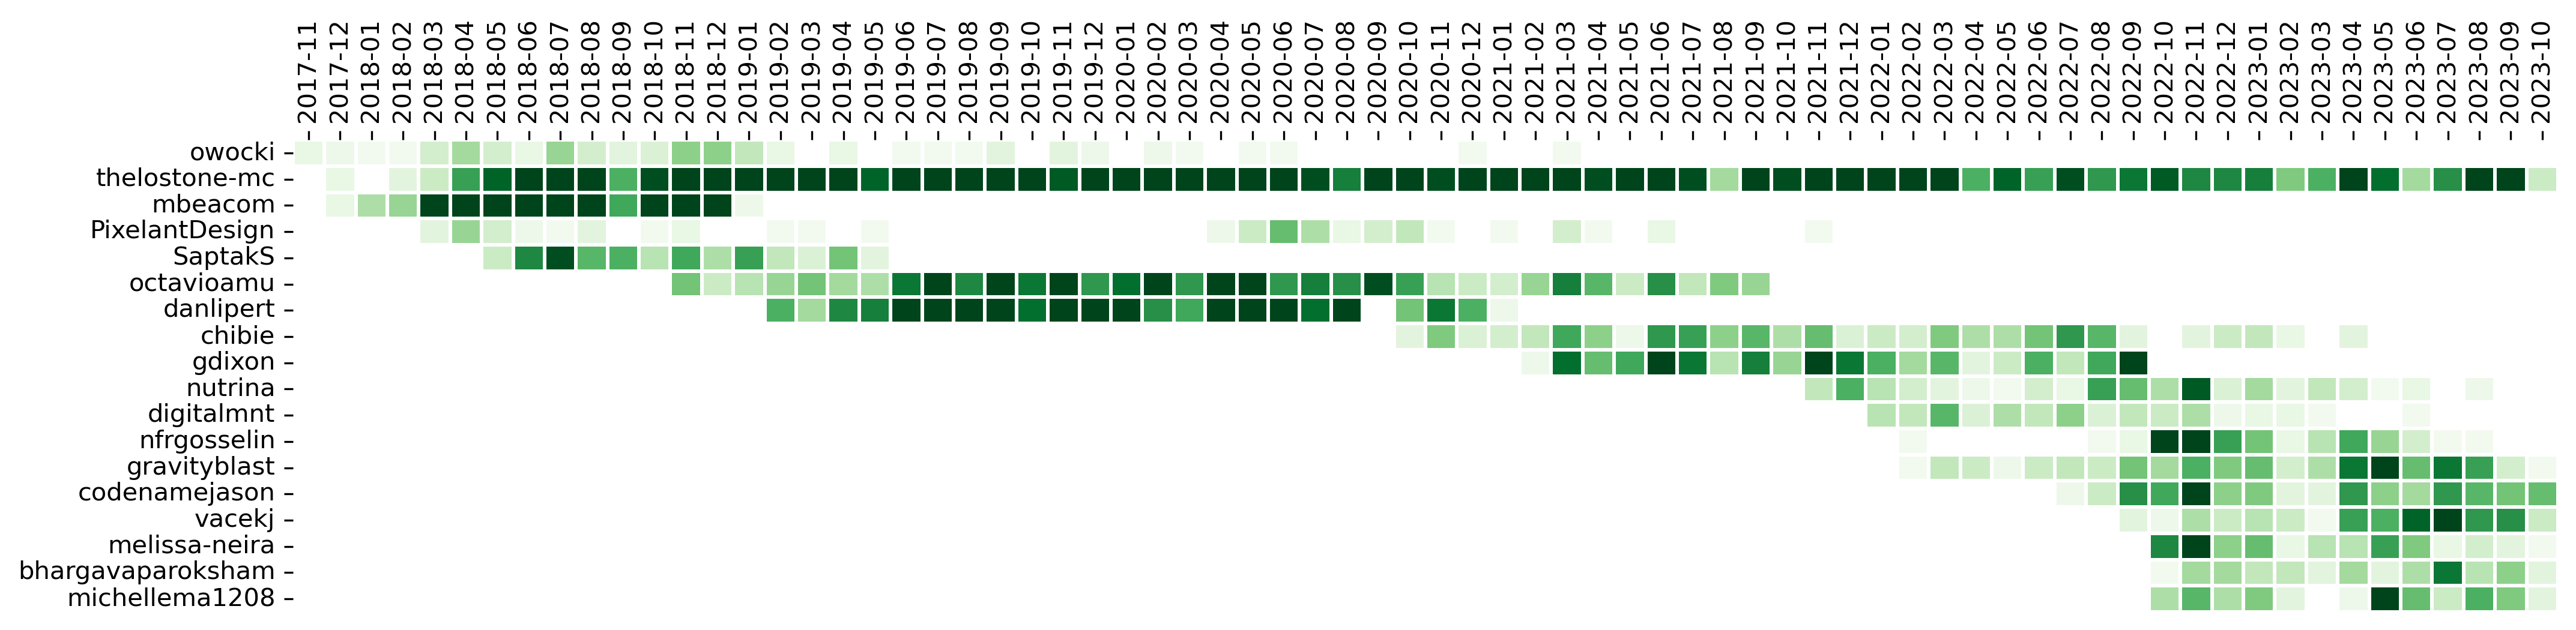

In [20]:
# Maintainers

pr_counts = df[df['event_type']=='PULL_REQUEST_APPROVED']['contributor_name'].value_counts()
pr_counts = pr_counts[pr_counts>=100]

dff = df[df['contributor_name'].isin(pr_counts.index)]
dff = dff[dff['event_type'].isin(['PULL_REQUEST_APPROVED'])]

contribution_heatmap(
    dff,
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=30,
)

(<Figure size 4440x1140 with 1 Axes>, <AxesSubplot:>)

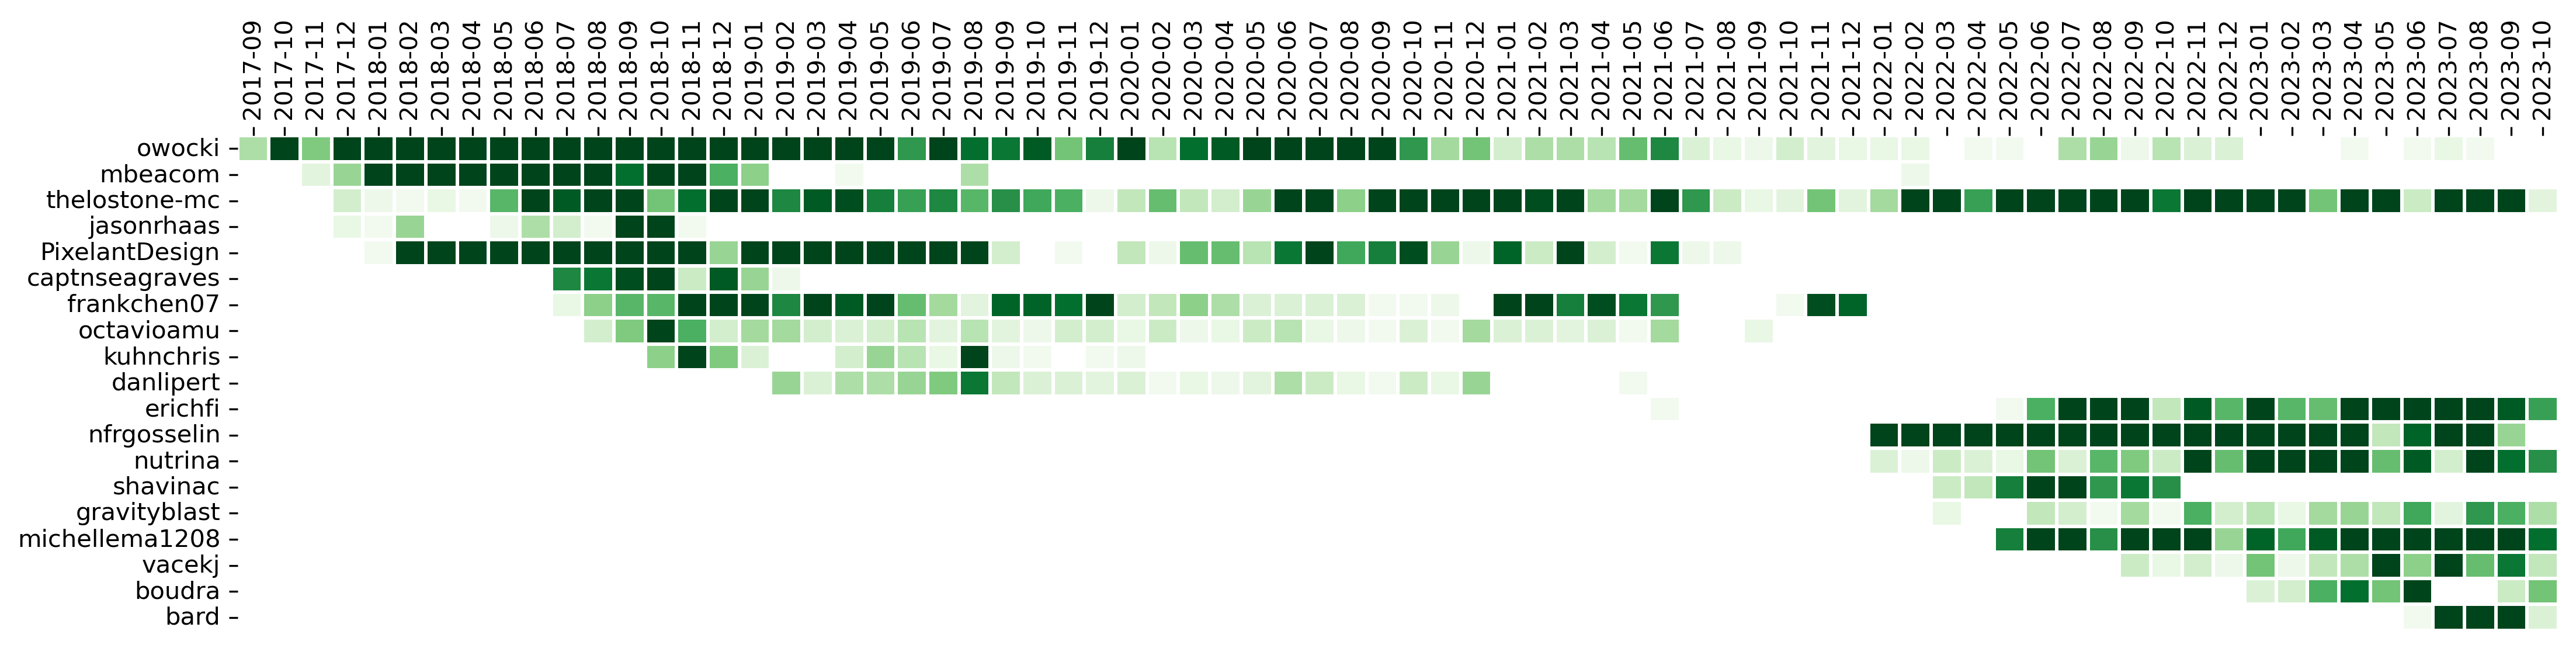

In [21]:
# issue ninjas

issue_creators = df[df['event_type']=='ISSUE_CREATED']['contributor_name'].value_counts()
issue_closers = df[df['event_type']=='ISSUE_CLOSED']['contributor_name'].value_counts()

issue_ninjas = set(issue_creators[issue_creators>=50].index).intersection(set(issue_closers[issue_closers>=50].index))

dff = df[df['contributor_name'].isin(issue_ninjas)]
dff = dff[dff['event_type'].str.contains('ISSUE')==True]

contribution_heatmap(
    dff,
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=30,
)

In [22]:
# Early committers: the first three contributors to commit to any repo that has since received more than 100 stars

starred_repos = df[df['event_type']=='STARRED'].groupby('github_repo')['event_time'].count()
starred_repos = starred_repos[starred_repos>=100]

early_committers = {}
for repo, stars in starred_repos.items():
    dff = df[(df['github_repo']==repo) & (df['event_type']=='COMMIT_CODE')]
    committers = dff.groupby('contributor_name')['date'].min()
    if len(committers) < 3:
        continue
    early_committers[repo] = committers.head(3)
    
pd.DataFrame(early_committers).sort_index().fillna("")    

gitcoinco/creative gitcoinco/grants-stack  \
contributor_name                                               
0xKurt                                            2023-02-03   
0xZakk                                                         
0xrishabh                                                      
7ada                       2020-06-03                          
ATorbMain                  2020-03-19                          
ArslanYM                                          2023-09-19   
AvrilApril                 2020-05-25                          
DanieleSalatti                                    2022-08-06   
Developer-piyush                                               
GuistF                                                         
Kweiss                                                         
MladenPetronijevic                                             
PixelantDesign                                                 
Rask467                                                        
aminah-io                                                      
chibie                                                         
f10et                                                          
jasonrhaas                                                     
ltfschoen                                                      

                   gitcoinco/kudosbadges gitcoinco/passport  \
contributor_name                                              
0xKurt                                                        
0xZakk                                                        
0xrishabh                                                     
7ada                                                          
ATorbMain                                                     
ArslanYM                                                      
AvrilApril                                                    
DanieleSalatti                                                
Developer-piyush                                              
GuistF                        2019-06-06                      
Kweiss                                           2023-01-17   
MladenPetronijevic            2018-07-24                      
PixelantDesign                2018-07-20                      
Rask467                                                       
aminah-io                                        2022-08-03   
chibie                                           2023-01-17   
f10et                                                         
jasonrhaas                                                    
ltfschoen                                                     

                   gitcoinco/passport-scorer gitcoinco/smart_contracts  \
contributor_name                                                         
0xKurt                                                                   
0xZakk                            2023-01-30                             
0xrishabh                                                                
7ada                                                                     
ATorbMain                                                                
ArslanYM                                                                 
AvrilApril                                                               
DanieleSalatti                                                           
Developer-piyush                                                         
GuistF                                                                   
Kweiss                            2023-03-21                             
MladenPetronijevic                                                       
PixelantDesign                                                           
Rask467                           2023-05-08                             
aminah-io                                                                
chibie                                                                   
f10et             

# Backup

(<Figure size 2040x4740 with 1 Axes>, <AxesSubplot:>)

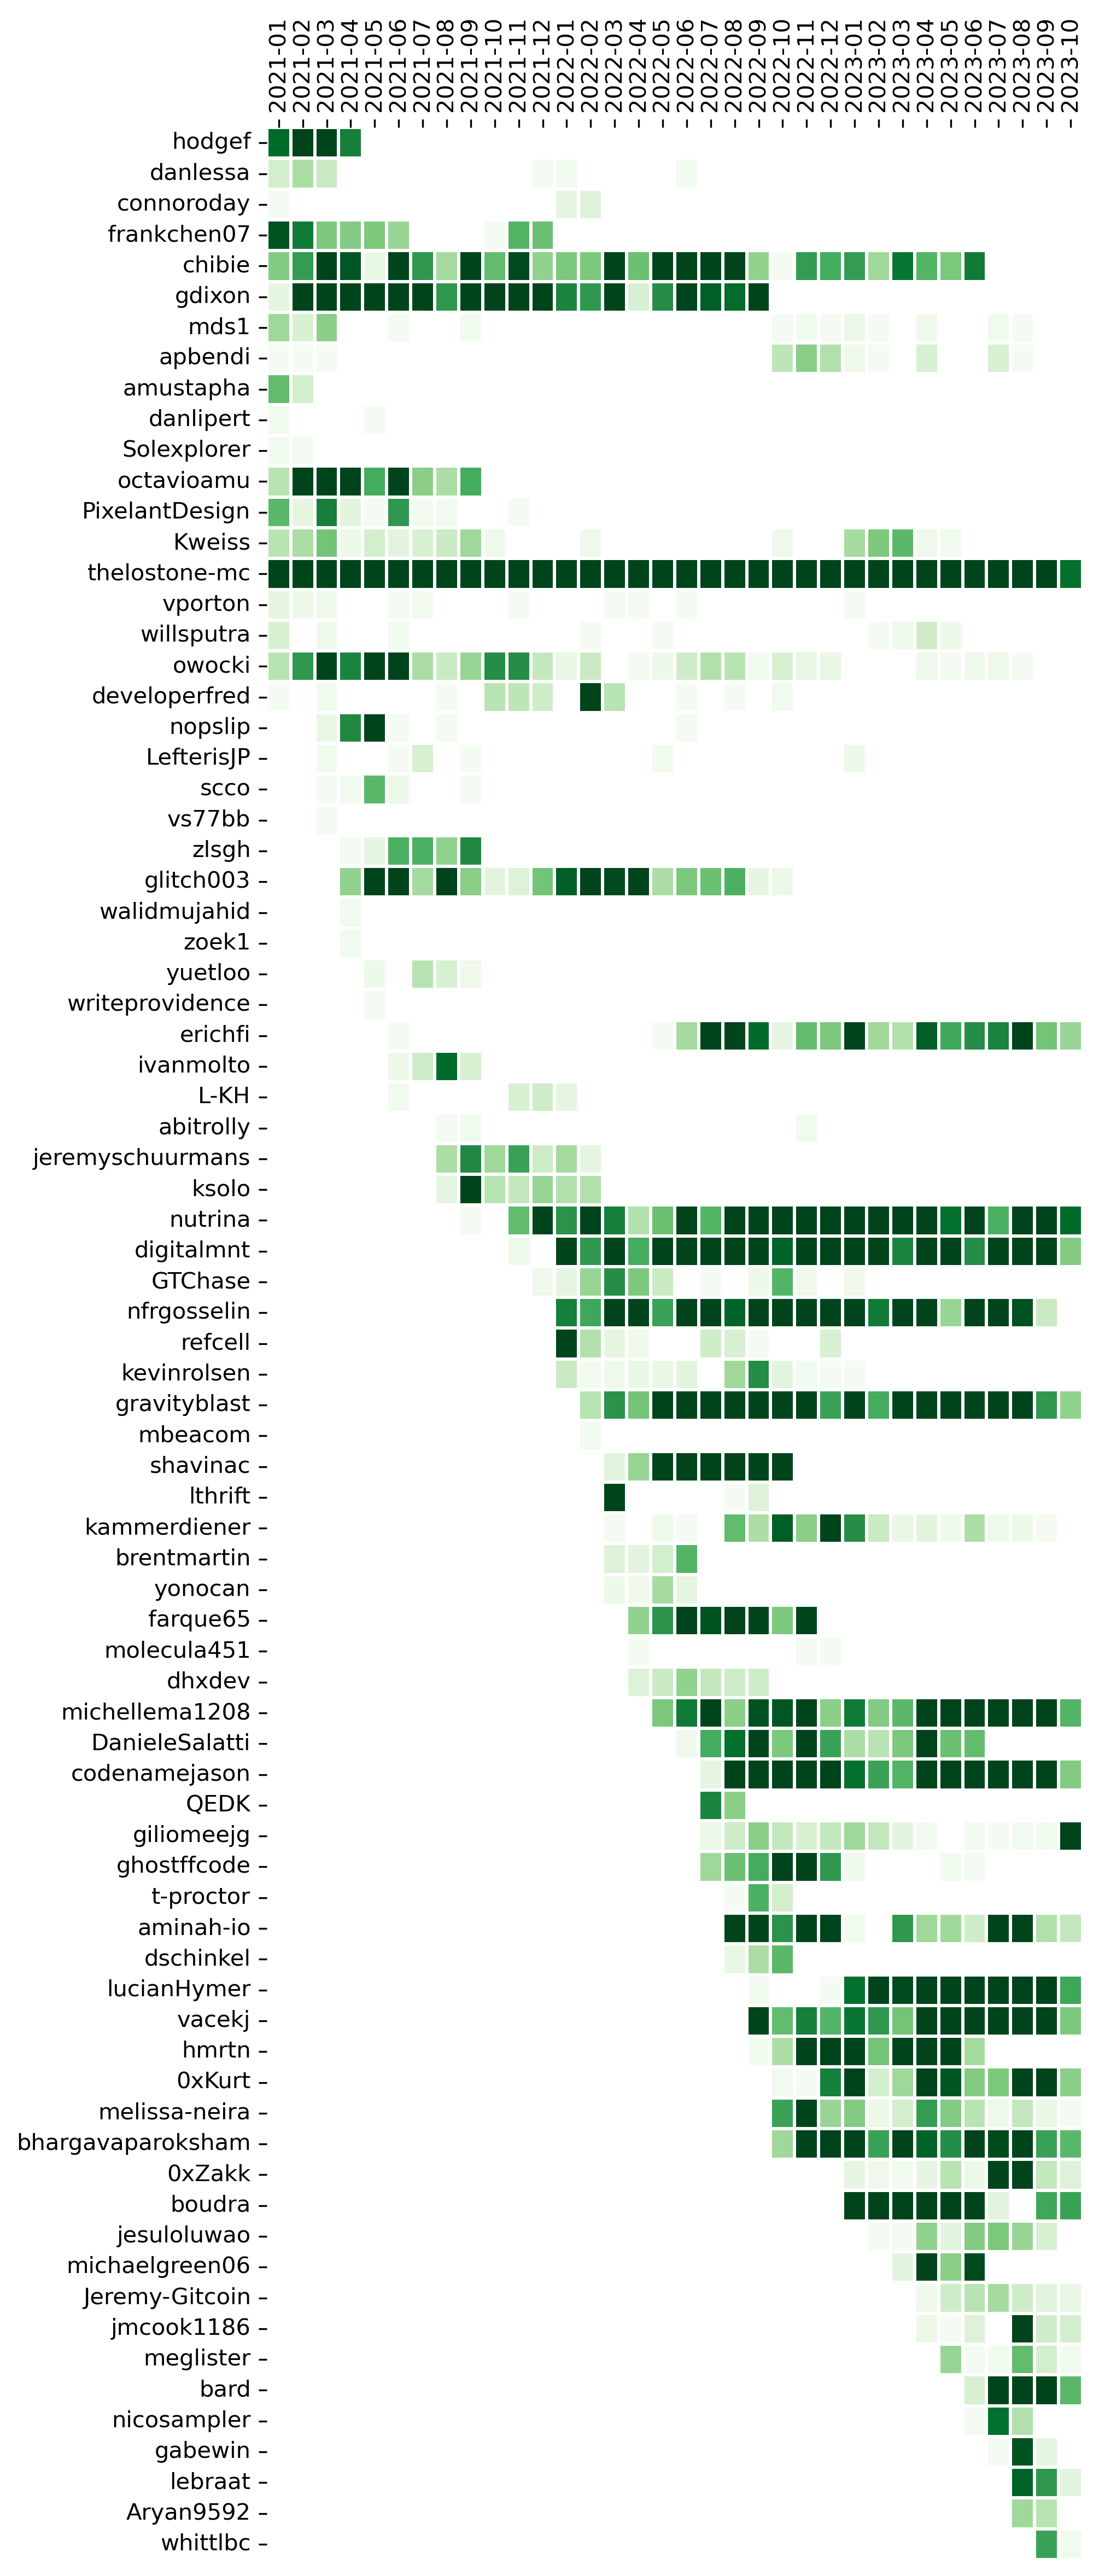

In [23]:
dff = df[df['month'] >= '2021-01'] 
dff = dff[dff['contributor_name'].isin(top_contribs)]
dff = dff[dff['event_type'].isin(EVENT_TYPES)]

contribution_heatmap(
    dff,
    index_col='contributor_name',
    column_col='month',
    value_col='event_time',
    apply_groupby=True,
    vmax=50,
)

In [24]:
df[df['event_type'] == 'PULL_REQUEST_APPROVED']['contributor_name'].value_counts().head(20)

contributor_name
thelostone-mc        2209
octavioamu            718
danlipert             665
mbeacom               557
gdixon                355
chibie                303
gravityblast          253
codenamejason         230
vacekj                190
SaptakS               184
nutrina               171
nfrgosselin           170
melissa-neira         166
michellema1208        149
owocki                120
bhargavaparoksham     119
digitalmnt            110
PixelantDesign        101
boudra                 99
shavinac               96
Name: count, dtype: int64

In [25]:
df_issues = (
    df[df['event_type'].isin(['ISSUE_CLOSED','ISSUE_CREATED'])]
    .pivot_table(index='contributor_name', columns='event_type', values='event_time', aggfunc='count')
).dropna()
df_issues['NUM_ISSUES'] = df_issues.sum(axis=1)
df_issues.sort_values(by='NUM_ISSUES', ascending=False).head(20)

event_type        ISSUE_CLOSED  ISSUE_CREATED  NUM_ISSUES
contributor_name                                         
thelostone-mc           3536.0          324.0      3860.0
owocki                   635.0         1845.0      2480.0
PixelantDesign           446.0          840.0      1286.0
nfrgosselin              181.0          801.0       982.0
michellema1208           330.0          640.0       970.0
mbeacom                  391.0          350.0       741.0
erichfi                  173.0          451.0       624.0
frankchen07              152.0          446.0       598.0
nutrina                  145.0          274.0       419.0
octavioamu               168.0          166.0       334.0
kuhnchris                199.0          104.0       303.0
vacekj                   162.0           65.0       227.0
shavinac                 149.0           65.0       214.0
gdixon                   132.0           47.0       179.0
jasonrhaas                84.0           92.0       176.0
bard                      83.0           86.0       169.0
gravityblast              69.0           98.0       167.0
danlipert                102.0           65.0       167.0
vs77bb                    16.0          148.0       164.0
captnseagraves            67.0           94.0       161.0